In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import csv
from keras.utils import to_categorical
import os
from Bio import SeqIO
from collections import Counter
from itertools import product

from scipy import stats, special, spatial
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import importlib.util

import warnings
warnings.filterwarnings('ignore')

2023-04-21 18:53:39.485462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 18:53:39.591080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64
2023-04-21 18:53:39.591102: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-21 18:53:40.284006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: 

## Overview of the dataset

### what is the GC content?

In [2]:
def get_name_2(name):
    if 'IBT' in name:
        name = name.split(' IBT')[0]
    elif 'NRRL' in name:
        name = name.split(' NRRL')[0]
    elif 'CBS' in name:
        name = name.split(' CBS')[0]
    elif 'DTO' in name:
        name = name.split(' DTO')[0]
    elif 'DSM' in name:
        name = name.split(' DSM')[0]
    elif 'ITEM' in name:
        name = name.split(' ITEM')[0]
    elif 'var' in name:
        name = name.split(' var')[0]
    elif 'str' in name:
        name = name.split(' str')[0]        
    else:
        name = name.split(' R64-1-1')[0]
    name = name.replace('_',' ' )
    name = name.replace('.',' ' )
    return name

In [3]:
def gc_content(file):
    os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/fasta_dna') 
    gc=0
    total=0
    sequences = []
    for record in SeqIO.parse(file, 'fasta'): #save all the sequences in one list
        sequences.append(str(record.seq))
    for sequence in sequences:
        for n in sequence:
            if n == 'G' or n =='g' or n == 'C' or n == 'c':
                gc += 1
                total += 1
            else:
                total += 1
    gc_percentage = (gc*100)/total
    #print(unknown)
    return gc_percentage

In [4]:
'''
os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/fasta_dna') 
directory = '/home/caitlin/KCL_AI-gene_student_project/My_data/fasta_dna'

directory = os.fsencode(directory)

gc_percentages_df = pd.DataFrame(columns = ['Species' , 'gc_precentage']) 

# Loop through all the files in the directory

for files in os.listdir(directory):
    filename = os.fsdecode(files)
    if filename.endswith('dna.toplevel.fa'):
        if '_ibt_' in filename:
            name = filename.split('_ibt_')[0]
        elif '_nrrl_' in filename:
            name = filename.split('_nrrl_')[0]
        elif '_cbs_' in filename:
            name = filename.split('_cbs_')[0]
        elif '_dto_' in filename:
            name = filename.split('_dto_')[0]
        elif '_dsm_' in filename:
            name = filename.split('_dsm_')[0]
        elif '_item_' in filename:
            name = filename.split('_item_')[0]
        elif '_gca_' in filename:
            name = filename.split('_gca_')[0]
        else:
            name = filename.split('.dna.toplevel.fa')[0]
        name = name.replace('_',' ' )
        name = name.replace('.',' ' )
        gc_percentages_df = gc_percentages_df.append ({'Species' : name, 'gc percentage' : gc_content(files)}, 
                                                  ignore_index = True)
        
gc_percentages_df.to_csv('gc_percentage.csv', index = False)
'''

"\nos.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/fasta_dna') \ndirectory = '/home/caitlin/KCL_AI-gene_student_project/My_data/fasta_dna'\n\ndirectory = os.fsencode(directory)\n\ngc_percentages_df = pd.DataFrame(columns = ['Species' , 'gc_precentage']) \n\n# Loop through all the files in the directory\n\nfor files in os.listdir(directory):\n    filename = os.fsdecode(files)\n    if filename.endswith('dna.toplevel.fa'):\n        if '_ibt_' in filename:\n            name = filename.split('_ibt_')[0]\n        elif '_nrrl_' in filename:\n            name = filename.split('_nrrl_')[0]\n        elif '_cbs_' in filename:\n            name = filename.split('_cbs_')[0]\n        elif '_dto_' in filename:\n            name = filename.split('_dto_')[0]\n        elif '_dsm_' in filename:\n            name = filename.split('_dsm_')[0]\n        elif '_item_' in filename:\n            name = filename.split('_item_')[0]\n        elif '_gca_' in filename:\n            name = filename.split(

In [5]:
os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/my_features') 

gc_percentages_df = pd.read_csv('gc_percentage.csv')
for i, row in gc_percentages_df.iterrows():
    gc_percentages_df.at[i, 'Species'] = get_name_2(row['Species'])
gc_percentages_df.head()

Species  gc_precentage  gc percentage
0     Aspergillus novofumigatus            NaN      49.144882
1          Hyphopichia burtonii            NaN      34.825870
2       Aspergillus tubingensis            NaN      49.180367
3   Acidomyces sp richmondensis            NaN      49.701439
4  Acidomyces richmondensis bfw            NaN      49.336148

In [6]:
avg_gc = gc_percentages_df['gc percentage'].mean()
sc_gc = gc_content('Saccharomyces_cerevisiae.R64-1-1.dna.toplevel.fa')
sc_index = gc_percentages_df.index[gc_percentages_df['Species'] == 'Saccharomyces cerevisiae'].tolist()[0]
max_gc = gc_percentages_df['gc percentage'].max()
min_gc = gc_percentages_df['gc percentage'].min()

In [7]:
print(avg_gc)
print(sc_gc)
print(max_gc)
print(min_gc)

47.28846200380866
38.14786497278752
57.05193740384488
32.7682338629152


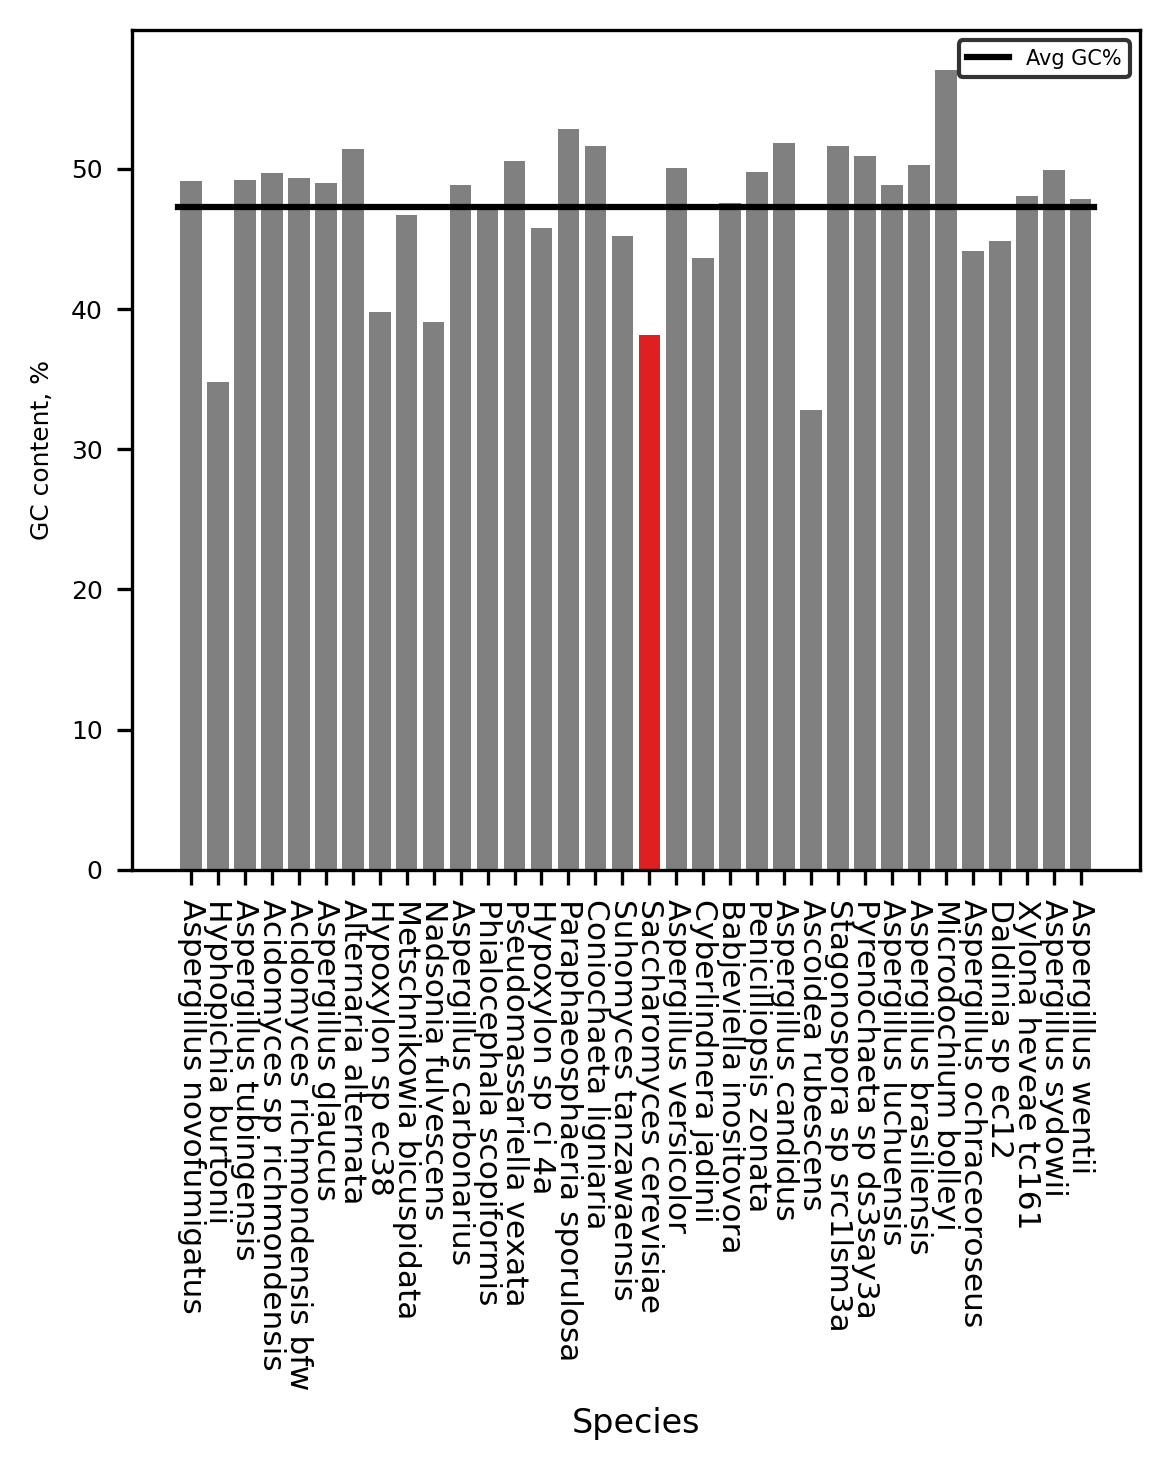

In [8]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize = (4, 5))

cols = ['red' if x == sc_gc else 'grey' for x in gc_percentages_df['gc percentage']]
gc_plot = sns.barplot(gc_percentages_df, x = 'Species', y = 'gc percentage', palette = cols, width = 0.8)

gc_plot.tick_params(axis = 'x', rotation = -90, labelsize = 8)
gc_plot.tick_params(axis = 'y', labelsize = 8)

plt.xticks(fontsize = 7.5)
plt.yticks(fontsize = 6)

avg_plot = plt.plot([-0.5, 33.5], [avg_gc, avg_gc], 'k')
plt.legend(avg_plot, ['Avg GC%'], facecolor = 'white', edgecolor = 'black', fontsize = 5)

gc_plot.set_ylabel('GC content, %', fontsize = 6)
gc_plot.set_xlabel('Species', fontsize = 8)

plt.tight_layout()

plt.savefig('gc_content.png')

### what are sizes of 5’ and 3’ UTR?

In [9]:
def get_name(name):
    if '_IBT_' in name:
        name = name.split('_IBT_')[0]
    elif '_NRRL_' in name:
        name = name.split('_NRRL_')[0]
    elif '_CBS_' in name:
        name = name.split('_CBS_')[0]
    elif '_DTO_' in name:
        name = name.split('_DTO_')[0]
    elif '_var._' in name:
        name = name.split('_var._')[0]    
    elif '_DSM_' in name:
        name = name.split('_DSM_')[0]
    elif '_ITEM_' in name:
        name = name.split('_ITEM_')[0]
    elif '_str._' in name:
        name = name.split('_str._')[0]        
    else:
        name = name.split('.R64-1-1')[0]
    name = name.replace('_',' ' )
    name = name.replace('.',' ' )
    return name

In [10]:
def three_UTR_length(file):
    #gene_names = []
    sequences = []
    lengths = []
    #df = pd.DataFrame(columns = ['gene', "3'UTR_length"])
    '''
    for line in file:
        if line.startswith('>'):
            header = line.strip()
            gene_name = header.split('gene=gene:')[1].split('seq_id=')[0]
            gene_names.append(gene_name)
    '''
    for record in SeqIO.parse(file, 'fasta'):
        sequences.append(record.seq)
    for i in range(len(sequences)):
        #df = df.append({'gene': gene_names[i], "3'UTR_length":len(sequences[i])}, ignore_index = True)
        lengths.append(len(sequences[i])) 
    #df.to_csv(name + '.3UTR_length' + '.csv', index = False)
    return lengths

In [11]:
def five_UTR_length(file):
    #gene_names = []
    sequences = []
    lengths = []
    #df = pd.DataFrame(columns = ['gene', "5'UTR_length"])
    '''
    for line in file:
        if line.startswith('>'):
            header = line.strip()
            gene_name = header.split('gene=gene:')[1].split('seq_id=')[0]
            gene_names.append(gene_name)
    '''
    for record in SeqIO.parse(file, 'fasta'):
        sequences.append(record.seq)
    for i in range(len(sequences)):
        #df = df.append({'gene': gene_names[i], "5'UTR_length":len(sequences[i])}, ignore_index = True)
        lengths.append(len(sequences[i])) 
    #df.to_csv(name + '.5UTR_length' + '.csv', index = False)
    return lengths

In [12]:
'''
directory_path = '/home/caitlin/KCL_AI-gene_student_project/My_data/my_features/all_features'
folder_path = []
folder_names = []


for folders in os.scandir(directory_path):
    if folders.is_dir():
        folder_path.append(os.path.join(directory_path, folders.name))
        folder_names.append(folders.name)

for i in range(len(folder_names)):
    folder_names[i] = get_name(folder_names[i])

UTR3_lengths_df = pd.DataFrame(columns = ['species', 'lengths'])
UTR5_lengths_df = pd.DataFrame(columns = ['species', 'lengths'])
    
for i in range(len(folder_path)):
    name = folder_names[i]
    os.chdir(folder_path[i])
    directory_in_str = folder_path[i]
    directory = os.fsencode(directory_in_str)
    for files in os.listdir(directory):
        decoded_files = files.decode()
        if decoded_files.endswith('.5utr'):
            lengths = five_UTR_length(files)
            for length in lengths:
                UTR5_lengths_df = UTR5_lengths_df.append({'species' : name, 'lengths' : length}, ignore_index = True)
        if decoded_files.endswith('.3utr'):
            lengths = three_UTR_length(files)
            for length in lengths:
                UTR3_lengths_df = UTR3_lengths_df.append({'species' : name, 'lengths' : length}, ignore_index = True)  

os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data')

UTR5_lengths_df.to_csv('UTR5_lengths.csv', sep = ',')
UTR3_lengths_df.to_csv('UTR3_lengths.csv', sep = ',') 
'''      

"\ndirectory_path = '/home/caitlin/KCL_AI-gene_student_project/My_data/my_features/all_features'\nfolder_path = []\nfolder_names = []\n\n\nfor folders in os.scandir(directory_path):\n    if folders.is_dir():\n        folder_path.append(os.path.join(directory_path, folders.name))\n        folder_names.append(folders.name)\n\nfor i in range(len(folder_names)):\n    folder_names[i] = get_name(folder_names[i])\n\nUTR3_lengths_df = pd.DataFrame(columns = ['species', 'lengths'])\nUTR5_lengths_df = pd.DataFrame(columns = ['species', 'lengths'])\n    \nfor i in range(len(folder_path)):\n    name = folder_names[i]\n    os.chdir(folder_path[i])\n    directory_in_str = folder_path[i]\n    directory = os.fsencode(directory_in_str)\n    for files in os.listdir(directory):\n        decoded_files = files.decode()\n        if decoded_files.endswith('.5utr'):\n            lengths = five_UTR_length(files)\n            for length in lengths:\n                UTR5_lengths_df = UTR5_lengths_df.append({'spe

In [13]:
os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/my_features')
directory = '/home/caitlin/KCL_AI-gene_student_project/My_data/my_features'
directory = os.fsencode(directory)

full_utr5_lens = pd.read_csv('UTR5_lens_full.csv')
full_utr3_lens = pd.read_csv('UTR3_lens_full.csv')

full_utr5_lens = full_utr5_lens.replace([0, -np.inf], np.nan).dropna(axis=0)
full_utr3_lens = full_utr3_lens.replace([0, -np.inf], np.nan).dropna(axis=0)

for i, row in full_utr5_lens.iterrows():
    full_utr5_lens.at[i, 'species'] = get_name(row['species'])
    
for i, row in full_utr3_lens.iterrows():
    full_utr3_lens.at[i, 'species'] = get_name(row['species'])

In [14]:
medians_5 = full_utr5_lens.groupby('species')['lengths'].median()
highest_median_5 = medians_5.max()
lowest_median_5 = medians_5.min()
medians_3 = full_utr3_lens.groupby('species')['lengths'].median()
highest_median_3 = medians_3.max()
lowest_median_3 = medians_3.min()

In [15]:
print(highest_median_5)
print(lowest_median_5)
print(highest_median_3)
print(lowest_median_3)

191.5
70.0
296.0
76.0


<Figure size 1800x900 with 0 Axes>

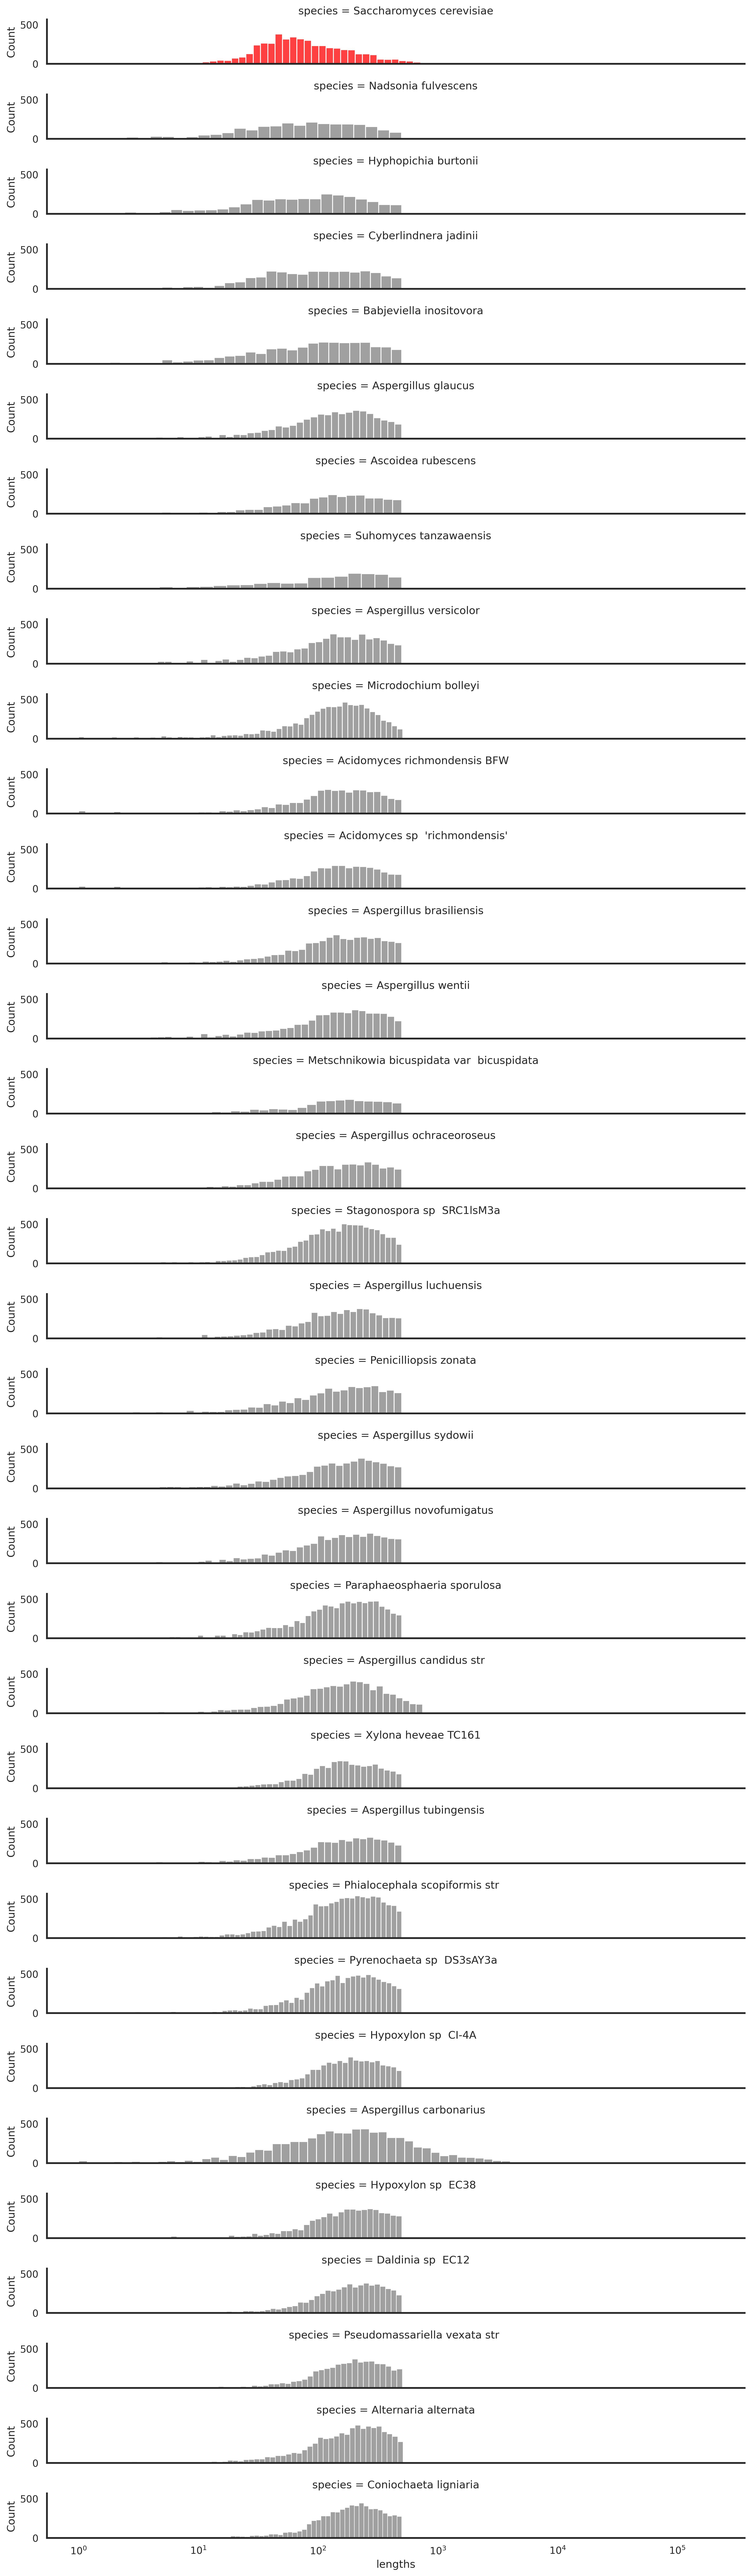

In [16]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 3))

sns.set_theme(style = "white", rc = {"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
species_palette = {'Saccharomyces cerevisiae': 'red', '': 'grey'}

palette = [species_palette.get(species, 'grey') for species in full_utr5_lens['species'].unique()]

medians = full_utr5_lens.groupby('species')['lengths'].median().sort_values().index
h_plot_5 = sns.FacetGrid(full_utr5_lens, row = 'species', hue = 'species', aspect = 10, height = 1.2,
                         row_order = medians, palette = palette)
h_plot_5.map_dataframe(sns.histplot, x = 'lengths', log_scale = True)

plt.tight_layout()

plt.savefig('UTR5_lengths.pdf')

<Figure size 1800x900 with 0 Axes>

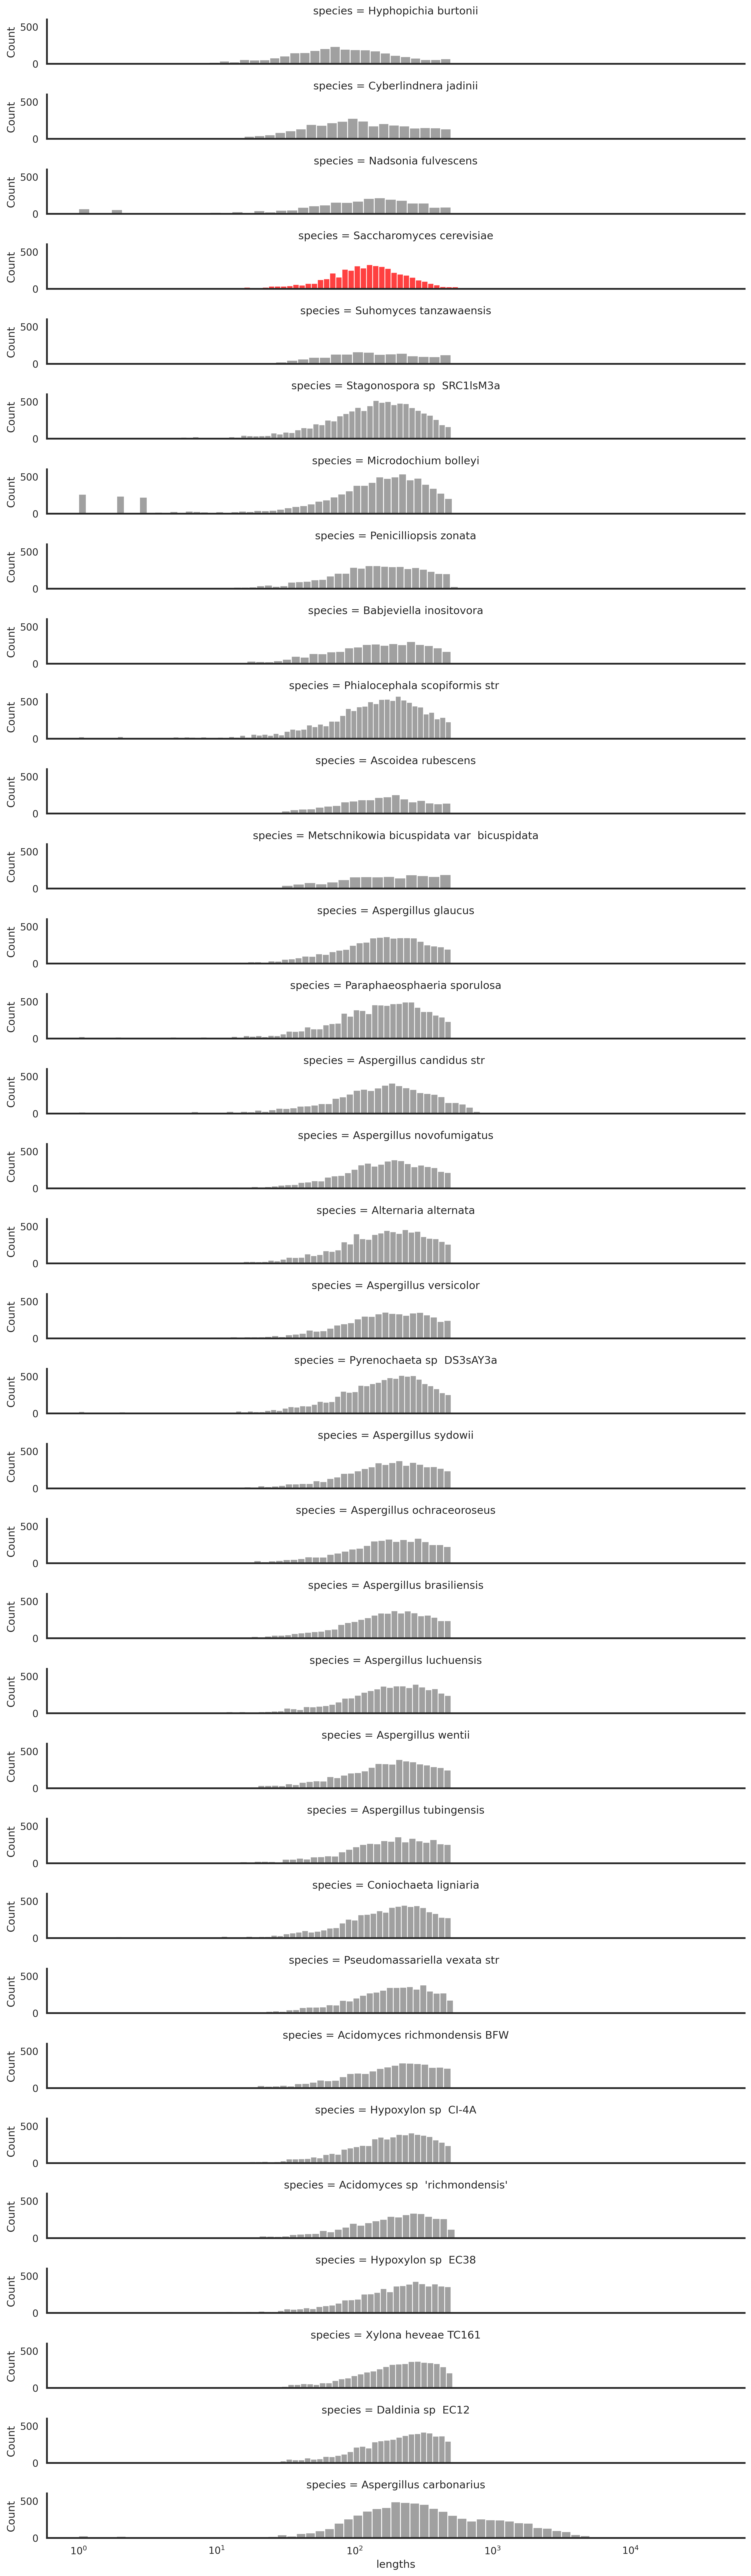

In [17]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 3))

sns.set_theme(style = "white", rc = {"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
species_palette = {'Saccharomyces cerevisiae': 'red', '': 'grey'}

palette = [species_palette.get(species, 'grey') for species in full_utr3_lens['species'].unique()]

medians = full_utr3_lens.groupby('species')['lengths'].median().sort_values().index
h_plot_3 = sns.FacetGrid(full_utr3_lens, row = 'species', hue = 'species', aspect = 10, height = 1.2,
                         row_order = medians, palette = palette)
h_plot_3.map_dataframe(sns.histplot, x = 'lengths', log_scale = True)

plt.tight_layout()

plt.savefig('UTR3_lengths.pdf')

### what are the codon composition frequencies?

In [18]:
def count_codons(file):
    '''codon frequency counter'''
    CodonsDict = {
        'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
        'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
        'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
        'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
        'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
        'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
        'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
        'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
        'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
        'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
        'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
        'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
        'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}

    # make the codon dictionary local
    codon_count = CodonsDict.copy()
    # iterate over sequence and count all the codons in the string.
    # make sure the sequence is upper case
    sequences = []
    total_codons = 0
    for record in SeqIO.parse(file, 'fasta'):
        sequences.append(record.seq)

    for seq in sequences:
        for i in range(0, len(seq), 3):
            total_codons += 1
            codon = seq[i:i + 3]
            if codon in codon_count:
                codon_count[codon] += 1
            else:
                continue
    # return values in dict with sorted keys alphabetically
    codon_freq_df = pd.DataFrame(columns = ['codon', 'frequency'])
    
    for key,value in sorted(codon_count.items()):
        #out.append(value/total_codons)
        codon_freq_df = codon_freq_df.append({'codon' : key, 'frequency' : (value/total_codons)*1000}, ignore_index = True)
    #output = np.asarray(out)

    return codon_freq_df

In [19]:
directory_path = '/home/caitlin/KCL_AI-gene_student_project/My_data/my_features/all_features'
folder_path = []
folder_names = []

for folders in os.scandir(directory_path):
    if folders.is_dir():
        folder_path.append(os.path.join(directory_path, folders.name))
        folder_names.append(folders.name)
        
for i in range(len(folder_names)):
    folder_names[i] = get_name_2(folder_names[i])

codons = ['AAA', 'AAG', 'AAC', 'AAT', 'AGA', 'AGG', 'AGC', 'AGT', 'ACA', 'ACG', 'ACC', 'ACT', 'ATA', 'ATG', 'ATC', 'ATT', 'GAA', 'GAG', 'GAC', 'GAT', 'GGA', 'GGG', 'GGC', 'GGT', 'GCA', 'GCG', 'GCC', 'GCT', 'GTA', 'GTG', 'GTC', 'GTT', 'CAA', 'CAG', 'CAC', 'CAT', 'CGA', 'CGG', 'CGC', 'CGT', 'CCA', 'CCG', 'CCC', 'CCT', 'CTA', 'CTG', 'CTC', 'CTT', 'TAA', 'TAG', 'TAC', 'TAT', 'TGA', 'TGG', 'TGC', 'TGT', 'TCA', 'TCG', 'TCC', 'TCT', 'TTA', 'TTG', 'TTC', 'TTT']

full_codon_freqs = pd.DataFrame(columns = folder_names, index = codons)

for i in range(len(folder_path)):
    species = folder_names[i]
    os.chdir(folder_path[i])
    directory = folder_path[i]
    directory = os.fsencode(directory)
    for file in os.listdir(directory):
        decoded_file = file.decode()
        if decoded_file.endswith('.CDS'):
            codon_freq = count_codons(file)
            for i, row in codon_freq.iterrows():
                full_codon_freqs.loc[row['codon'], species] = float(row['frequency'])

In [20]:
os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/my_features')
full_codon_freqs.to_csv('codon_frequencies.csv')

In [21]:
frequency_df = pd.DataFrame(columns = ['frequency', 'codon', 'species'])

for codon, row in full_codon_freqs.iterrows():
    for species, freq in row.iteritems():
        frequency_df = frequency_df.append({'frequency': freq, 'codon': codon, 'species': species}, ignore_index=True)
        
frequency_df['codon'] = pd.Categorical(frequency_df['codon'], categories = codons, ordered=True)

for i, row in frequency_df.iterrows():
    frequency_df.at[i, 'species'] = get_name_2(row['species'])

frequency_df.head()

frequency codon                     species
0  16.787439   AAA          Hypoxylon sp  EC38
1  15.450553   AAA   Aspergillus novofumigatus
2  16.203103   AAA         Aspergillus sydowii
3  53.373882   AAA        Hyphopichia burtonii
4  15.359857   AAA  Stagonospora sp  SRC1lsM3a

In [22]:
frequency_df['species'] = pd.Categorical(frequency_df['species'])
heatmap_df = frequency_df.pivot(index='codon', columns='species', values='frequency')

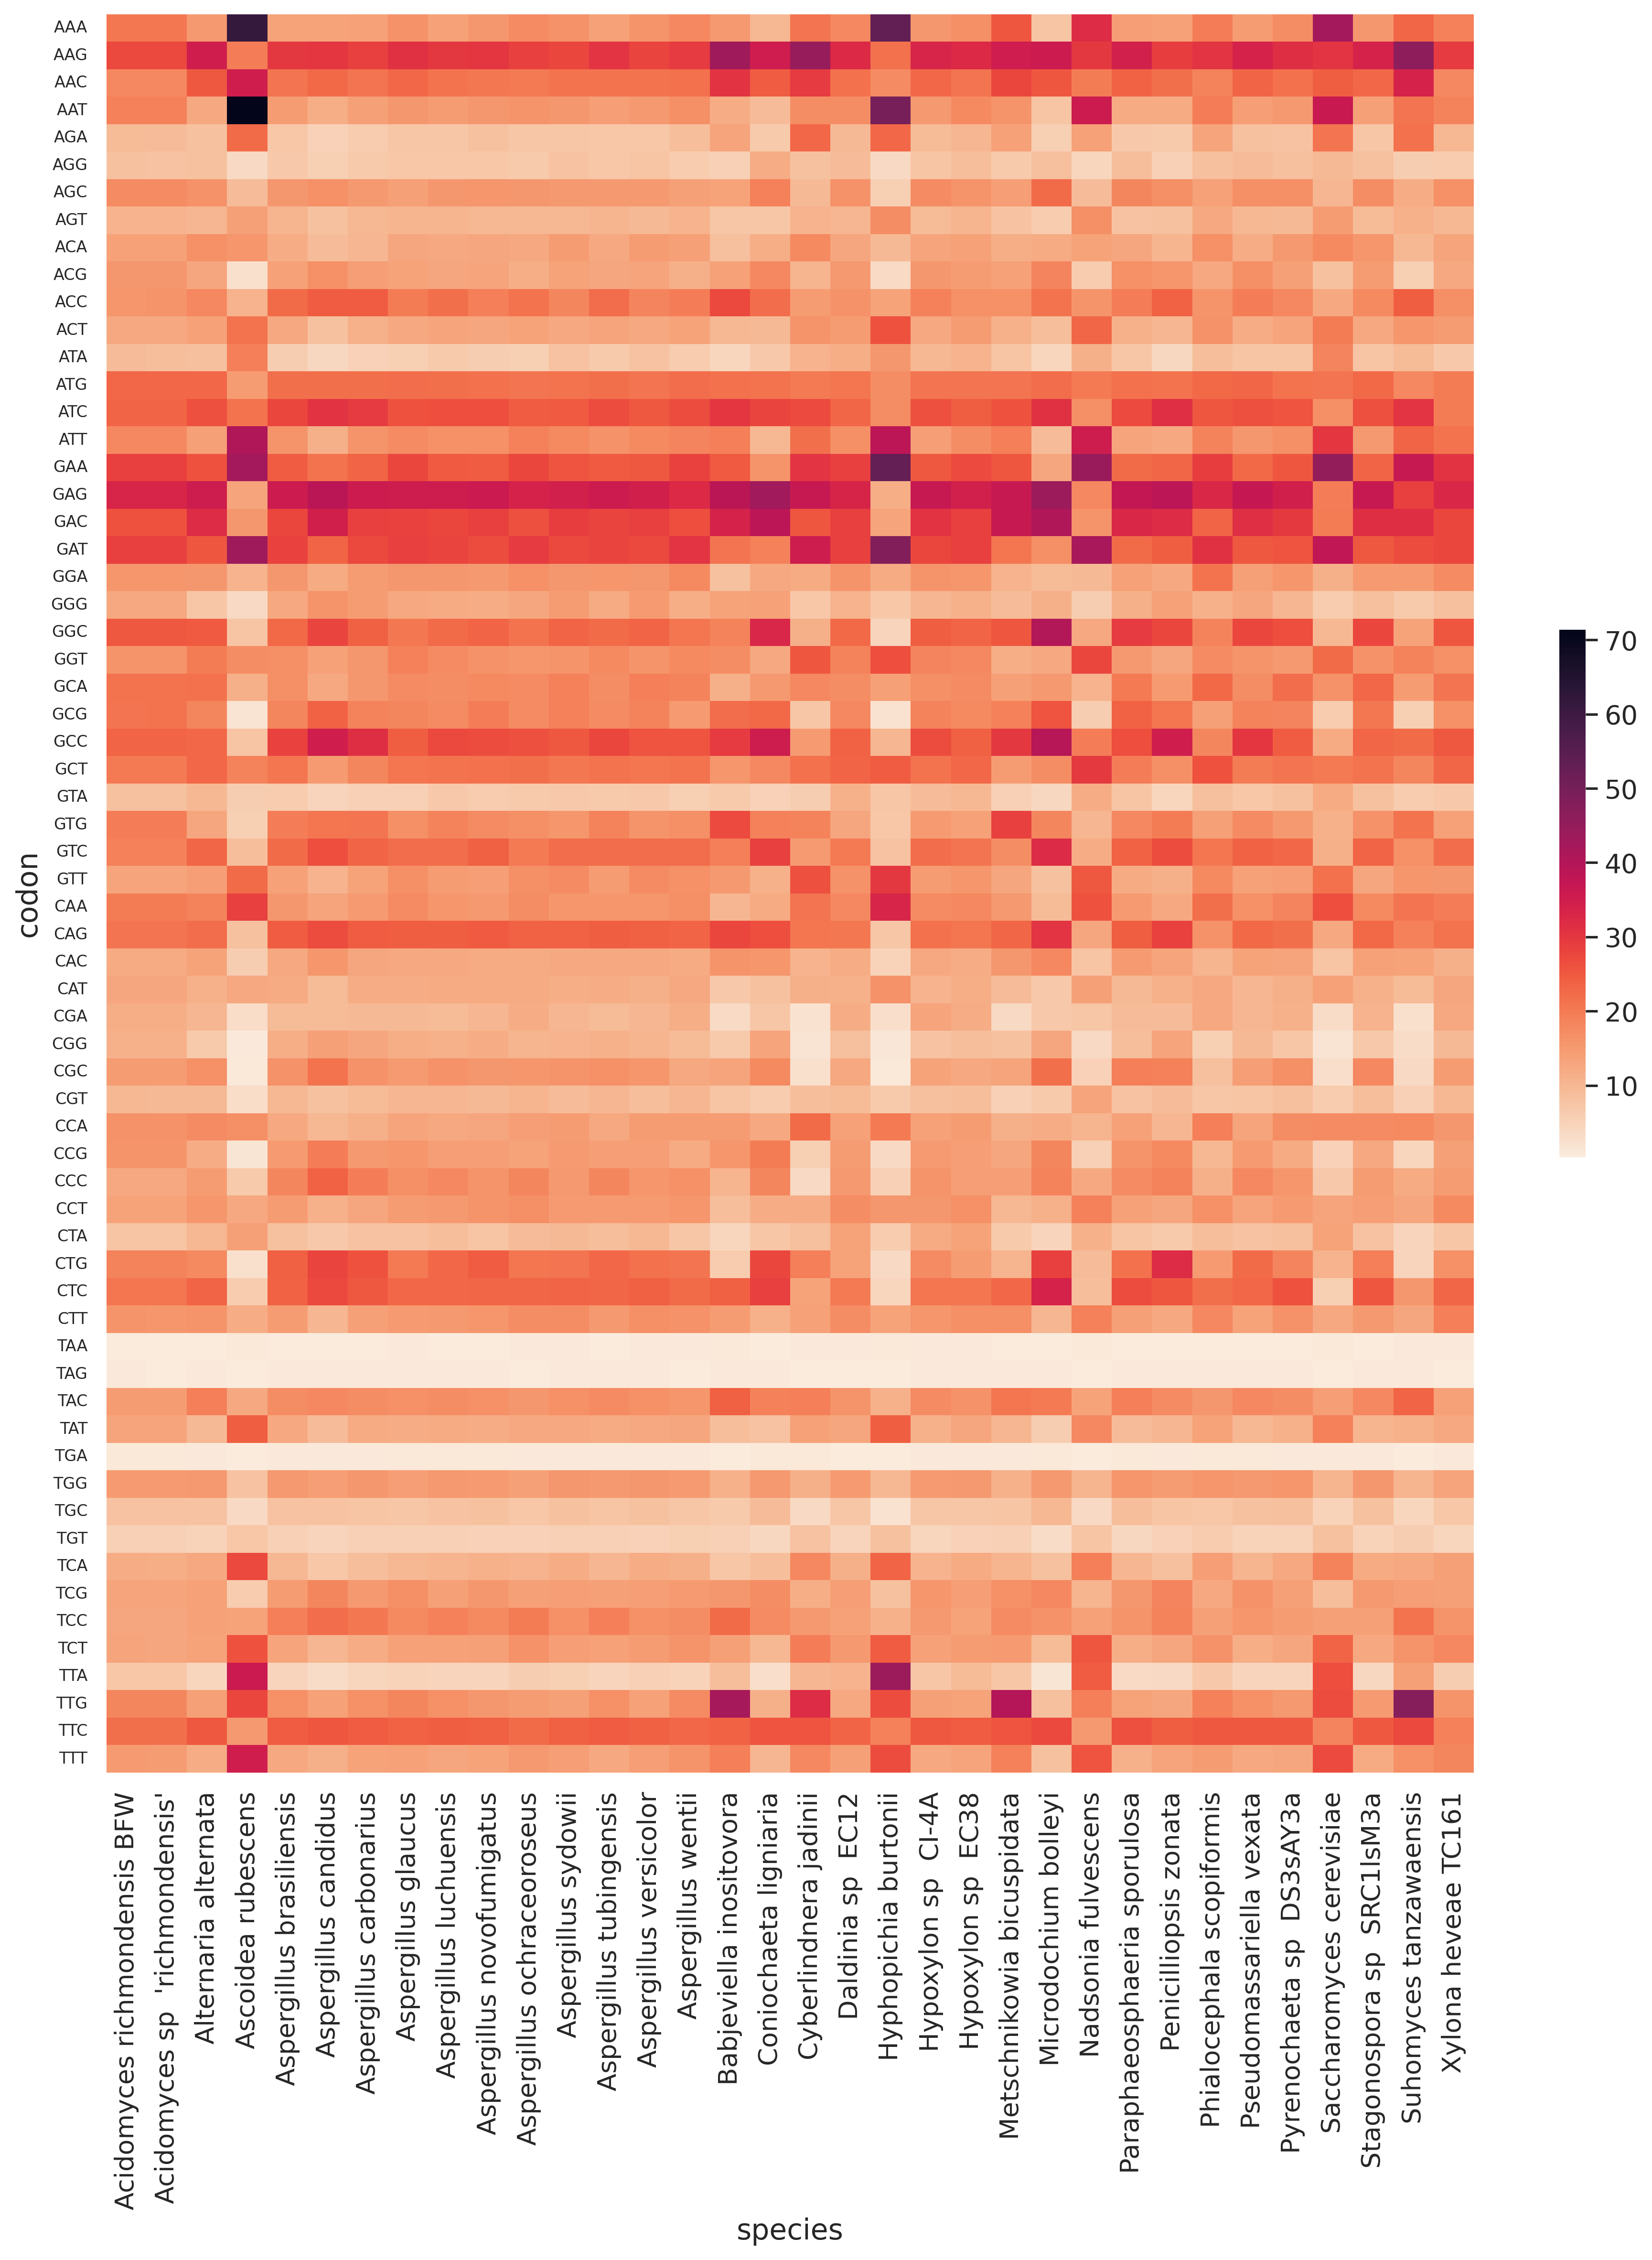

In [23]:
plt.figure(figsize = (13, 16))
sns.set(font_scale = 1.2)
cmap = sns.cm.rocket_r

f_heatmap = sns.heatmap(heatmap_df, cbar_kws = {'shrink': 0.3}, cmap = cmap)

f_heatmap.set_xticklabels(f_heatmap.get_xticklabels(), rotation = 90, fontsize = 13)
f_heatmap.set_yticklabels(f_heatmap.get_yticklabels(), fontsize = 8)

plt.tight_layout()
plt.savefig('codon_heatmap.png')
plt.show()

## Predictions statistics

### Are there species that have, on average, significantly higher gene expression distributions, if so, how many of them, and what are they?

In [24]:
def get_name_3(name):
    if '_var._' in name:
        name = name.split('_var._')[0]
    elif '_str._' in name:
        name = name.split('_str._')[0]     
    elif '_IBT_' in name:
        name = name.split('_IBT_')[0]
    elif '_NRRL_' in name:
        name = name.split('_NRRL_')[0]
    elif '_CBS_' in name:
        name = name.split('_CBS_')[0]
    elif '_DTO_' in name:
        name = name.split('_DTO_')[0]
    elif '_DSM_' in name:
        name = name.split('_DSM_')[0]
    elif '_ITEM_' in name:
        name = name.split('_ITEM_')[0]       
    else:
        name = name.split('.dna.toplevel.fa')[0]
    name = name.replace('_',' ' )
    name = name.replace('.',' ' )
    return name

In [25]:
os.chdir('/home/caitlin/KCL_AI-gene_student_project/My_data/my_features/') 

pred_df = pd.read_csv('predictions_complete.csv')
pred_df = pred_df.drop('Unnamed: 0', axis=1)
pred_df = pred_df[pred_df['model_prediction'] > 0].dropna()

In [26]:
for i, row in pred_df.iterrows():
    pred_df.at[i, 'species'] = get_name_3(row['species'])

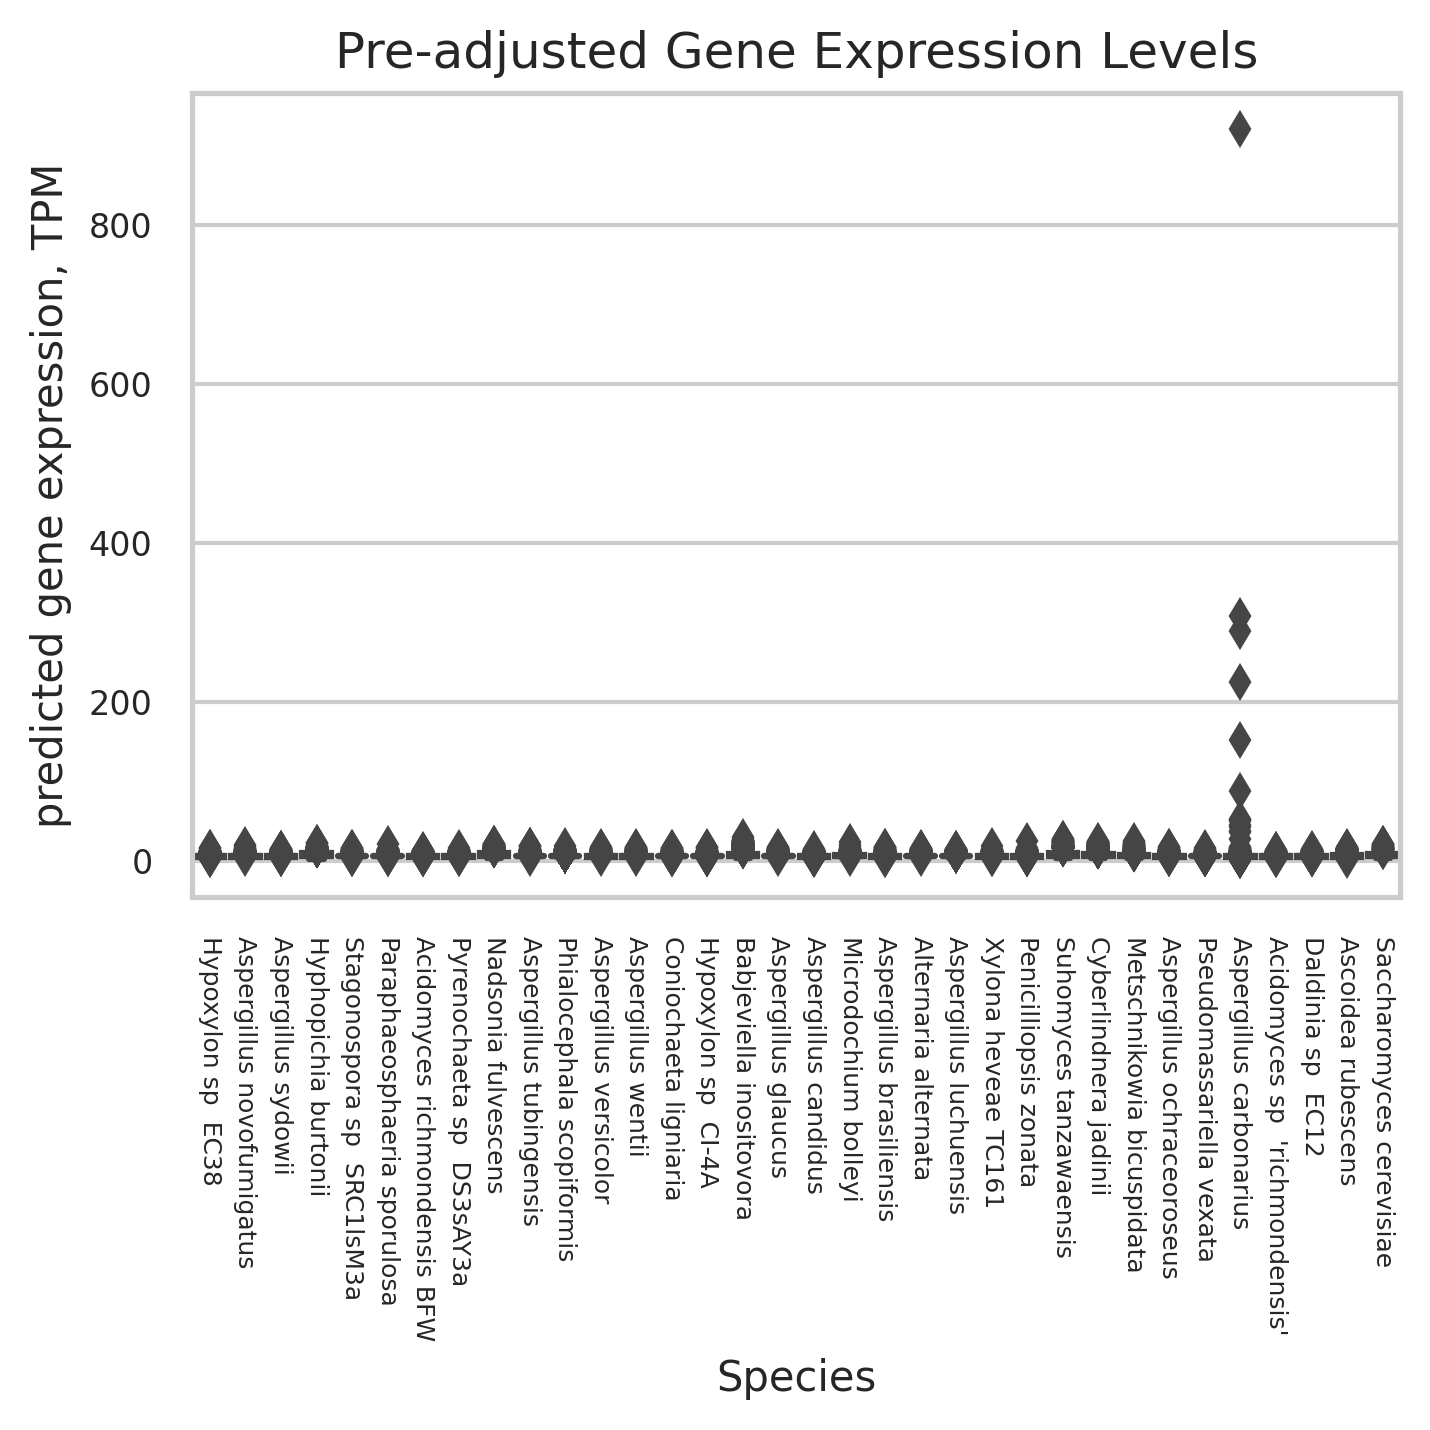

In [27]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize = (5, 5))
sns.set_style("whitegrid")
b_plot = sns.boxplot(x = 'species', y = 'model_prediction', data = pred_df)

b_plot.set_title('Pre-adjusted Gene Expression Levels', fontsize = 12)
b_plot.set_ylabel('predicted gene expression, TPM', fontsize = 10)
b_plot.set_xlabel('Species', fontsize = 10)
b_plot.tick_params(axis = 'x', rotation = -90, labelsize = 6)
b_plot.tick_params(axis = 'y', labelsize = 8)
plt.tight_layout()
plt.savefig('pre_adjusted_boxplot.png')
plt.show()

In [28]:
max_val = pred_df['model_prediction'].max()
species_val = pred_df.loc[pred_df['model_prediction'] == max_val, 'species'].iloc[0]

print(species_val)
print(max_val)

Aspergillus carbonarius
920.4781


In [29]:
adjusted_pred_df = pd.DataFrame(columns=pred_df.columns)

for species in pred_df['species'].unique():
    subset = pred_df.loc[pred_df['species'] == species, 'model_prediction']
    q75, q25 = np.percentile(subset, [75, 25])
    intr_qr = q75 - q25
    max_val = q75 + 1.5 * intr_qr
    subset = subset[subset <= max_val] 
    adjusted_pred_df = adjusted_pred_df.append(pred_df.loc[pred_df['species'] == species].loc[subset.index])

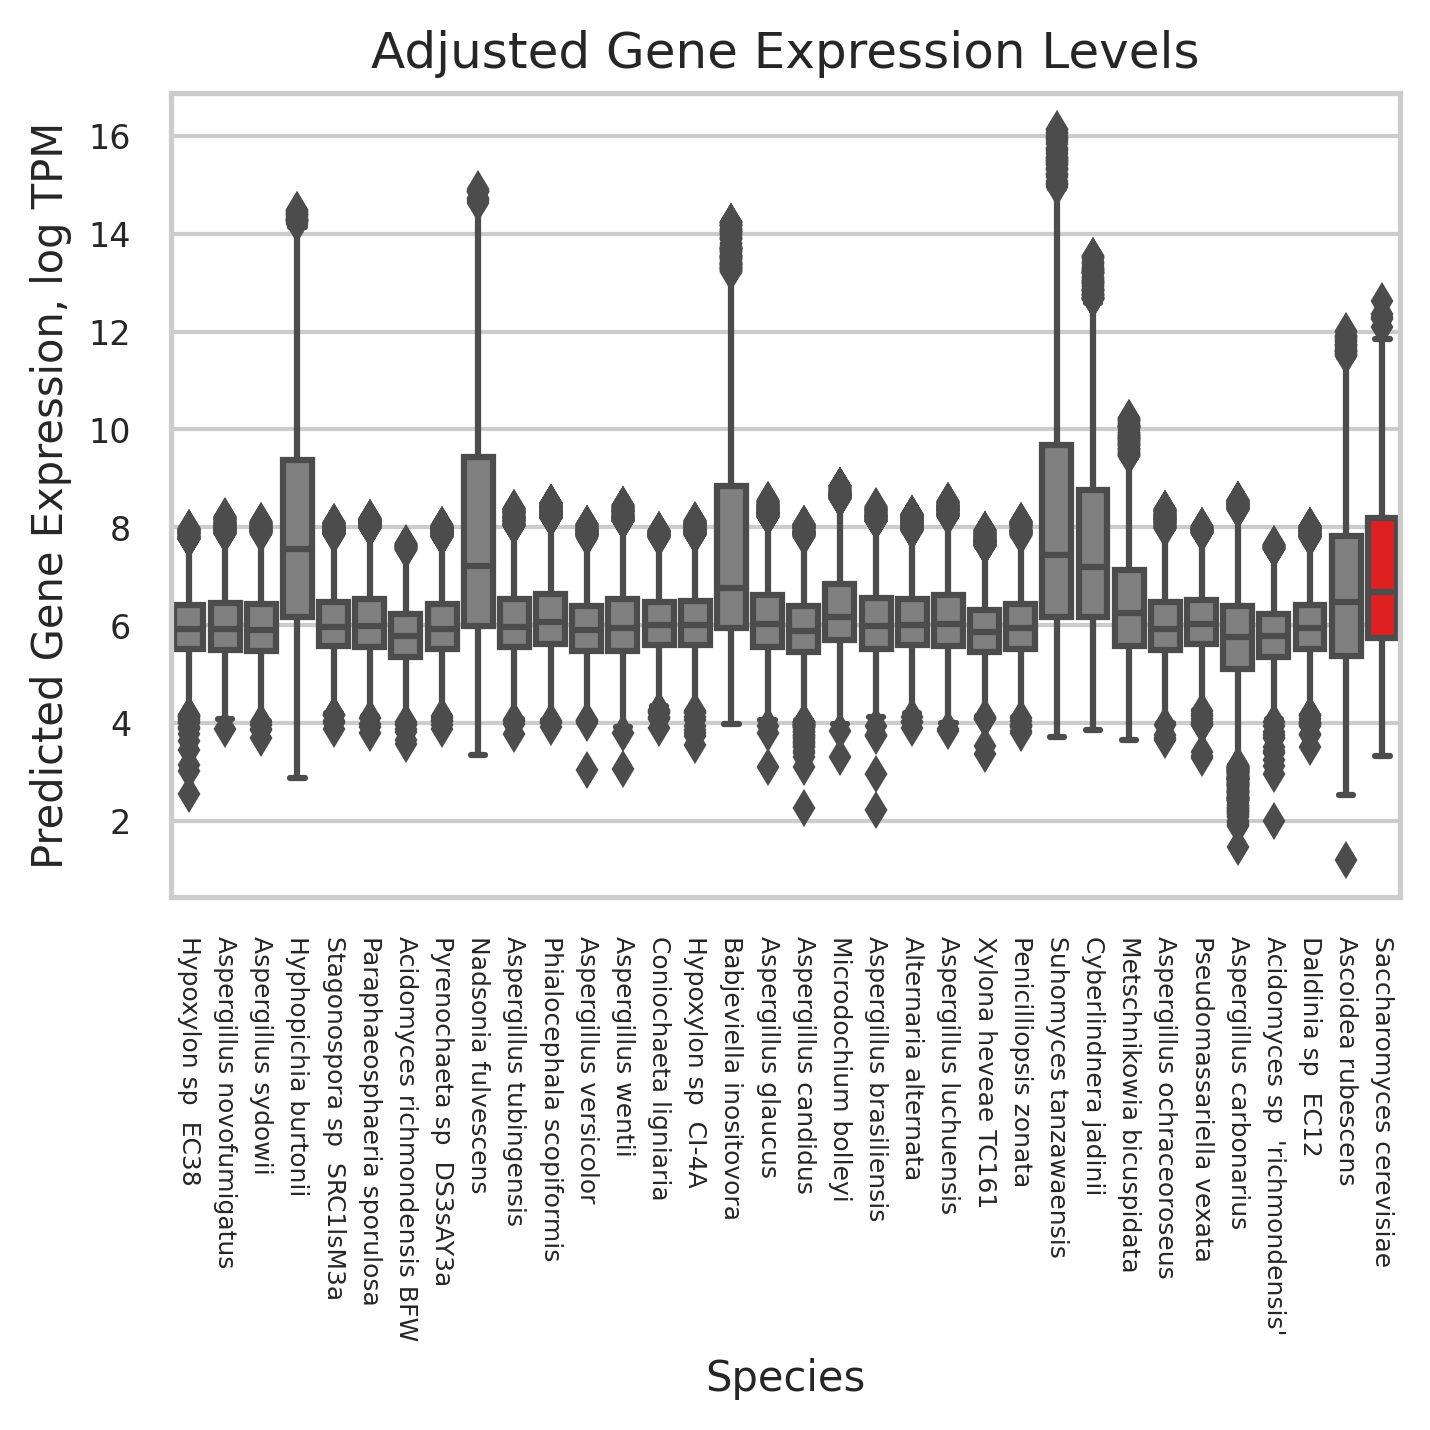

In [30]:
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")

palette = ['grey'] * len(adjusted_pred_df['species'].unique())
palette[adjusted_pred_df['species'].unique().tolist().index('Saccharomyces cerevisiae')] = 'red'

b_plot = sns.boxplot(x='species', y = 'model_prediction', data = adjusted_pred_df, palette = palette)

b_plot.set_title('Adjusted Gene Expression Levels', fontsize = 12)
b_plot.set_ylabel('Predicted Gene Expression, log TPM', fontsize = 10)
b_plot.set_xlabel('Species', fontsize = 10)
b_plot.tick_params(axis = 'x', rotation = -90, labelsize = 6)
b_plot.tick_params(axis='y', labelsize = 8)

plt.tight_layout()
plt.savefig('adjusted_boxplot.png')
plt.show()

In [31]:
max_val = adjusted_pred_df['model_prediction'].max()
species_val = adjusted_pred_df.loc[pred_df['model_prediction'] == max_val, 'species'].iloc[0]

print(species_val)
print(max_val)

Suhomyces tanzawaensis
16.13709


In [32]:
sc_df = adjusted_pred_df[adjusted_pred_df['species'] == 'Saccharomyces cerevisiae']
sc_median = sc_df['model_prediction'].median()
sc_90 = np.percentile(sc_df['model_prediction'], 90)

<Figure size 1800x900 with 0 Axes>

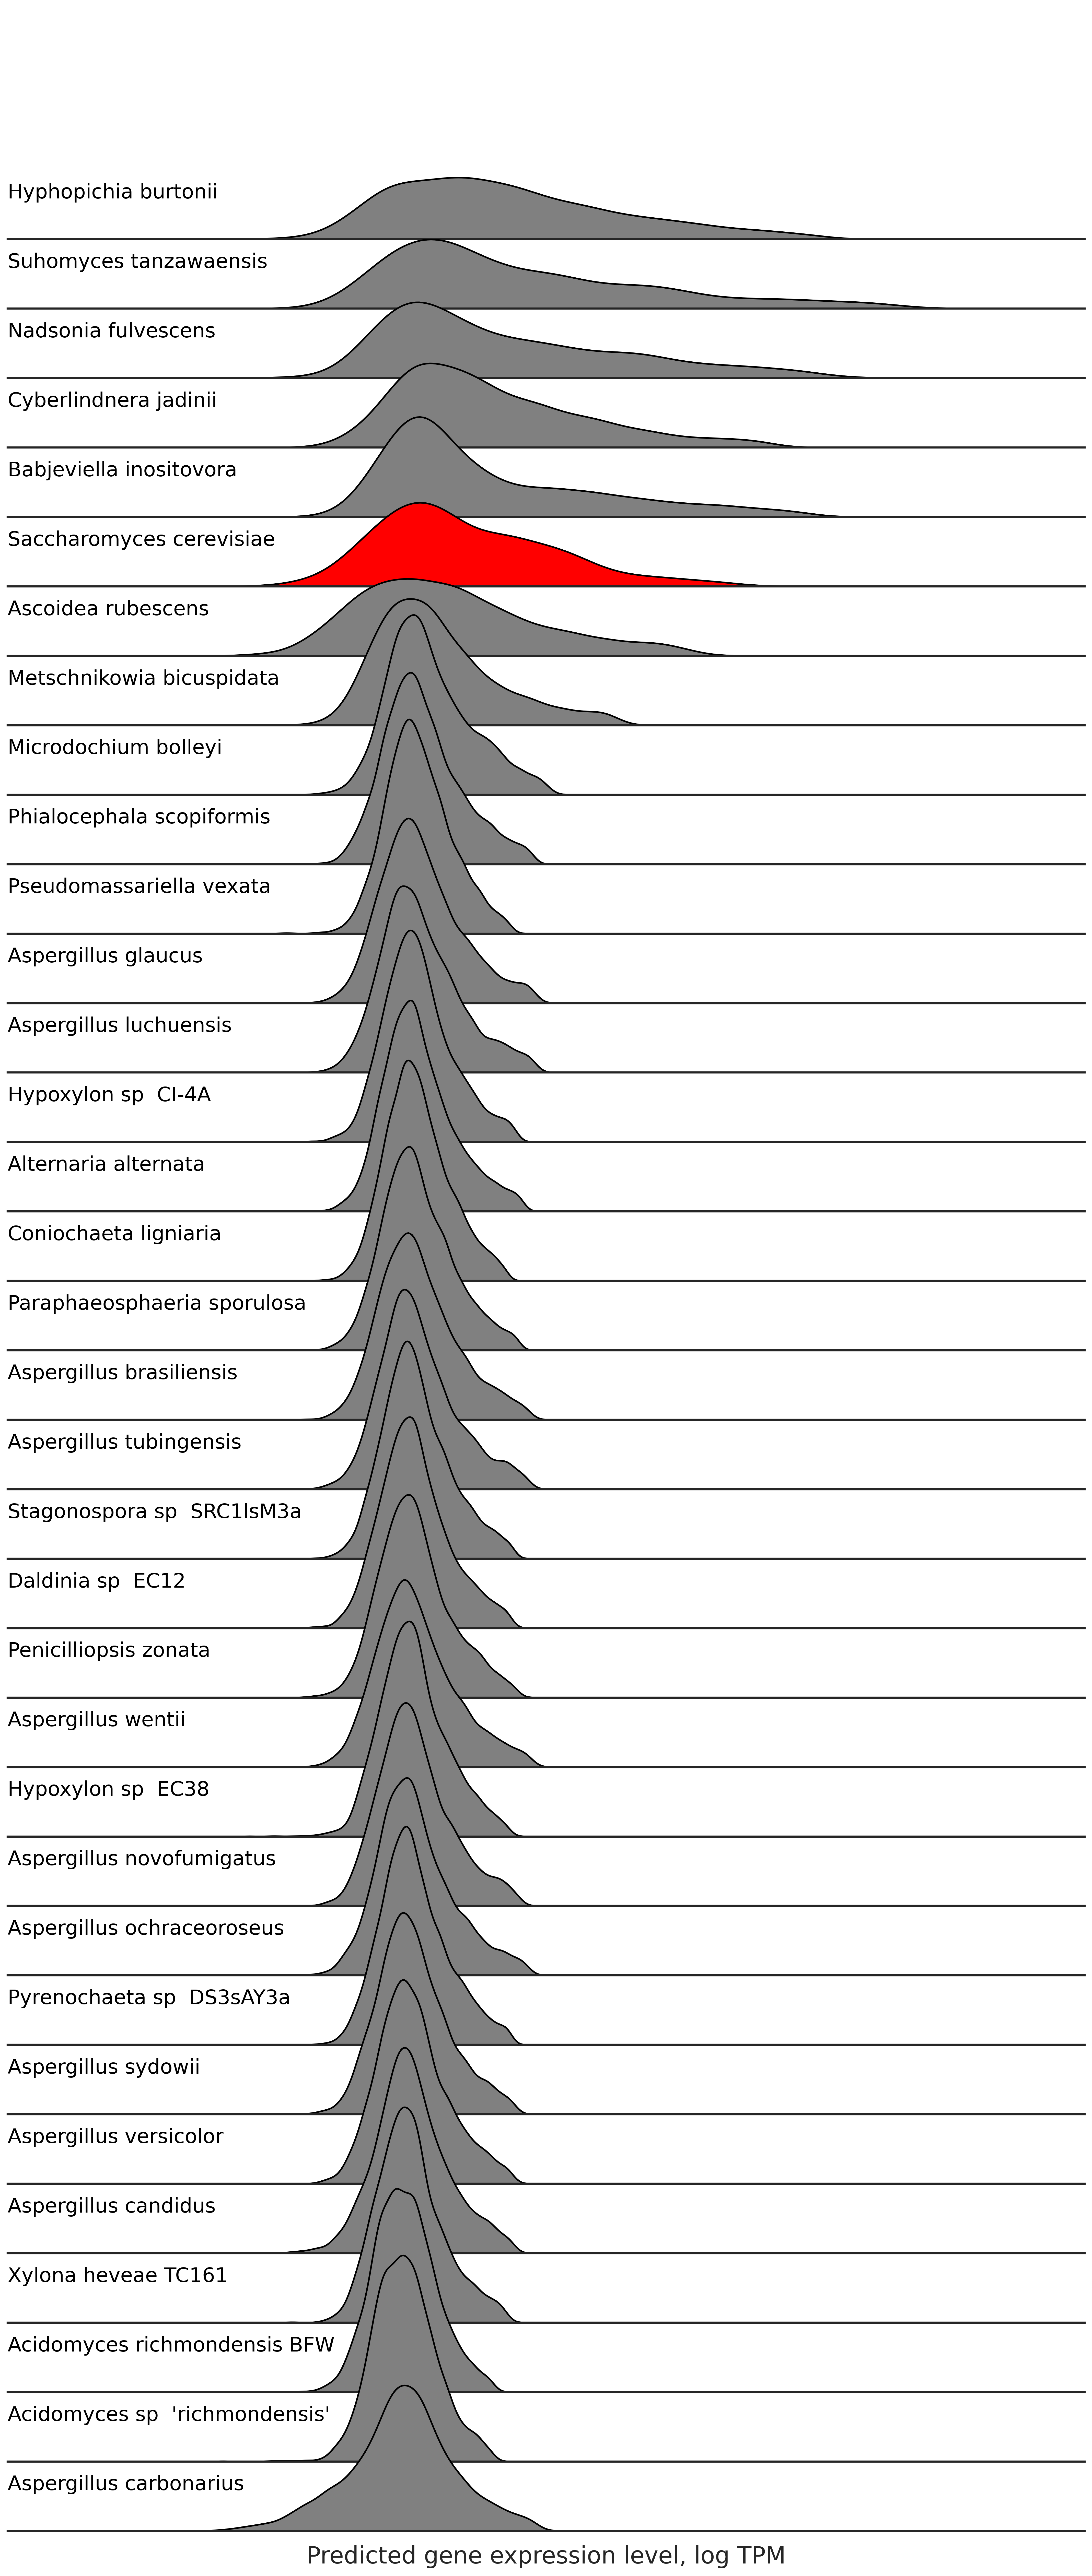

In [33]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 3))

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})

species_palette = {'Saccharomyces cerevisiae': 'red', '': 'grey'}

palette = [species_palette.get(species, 'grey') for species in adjusted_pred_df['species'].unique()]

median_df = adjusted_pred_df.groupby("species")["model_prediction"].median().reset_index()

order = median_df.sort_values("model_prediction", ascending = False)["species"]

r_plot = sns.FacetGrid(adjusted_pred_df, palette = palette, row = "species", hue='species',
                       row_order=order, aspect = 15, height=1)

r_plot.map_dataframe(sns.kdeplot, x='model_prediction', fill = True, alpha=1)
r_plot.map_dataframe(sns.kdeplot, x='model_prediction', color = 'black')

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, color = 'black', fontsize = 19,
            ha = "left", va = "center", transform = ax.transAxes)

r_plot.map(label, "species")
r_plot.fig.subplots_adjust(hspace = -.7)
r_plot.set_titles("")
r_plot.set(yticks = [], xlabel='Predicted gene expression level, log TPM', ylabel = None)
r_plot.set_xlabels('Predicted gene expression level, log TPM', fontsize = 22)
r_plot.set_xticklabels(fontsize=16)
r_plot.despine(left = True)

plt.savefig('pred_ridge_plot.png')

### How many genes have more mRNA expression than the max gene in S. cerevisiae?

In [34]:
sc = adjusted_pred_df.loc[adjusted_pred_df['species'] == 'Saccharomyces cerevisiae', 'model_prediction']
max_sc = sc.max()
print(max_sc)

12.624952


In [35]:
above_max_sc = adjusted_pred_df.loc[adjusted_pred_df['model_prediction'] > max_sc, 'species']
print(len(above_max_sc))

644


In [36]:
from scipy.stats import ranksums

sc_df = adjusted_pred_df[pred_df['species'] == 'Saccharomyces cerevisiae']

for species in adjusted_pred_df['species'].unique():
    if species == 'Saccharomyces cerevisiae':
        continue  
    species_df = adjusted_pred_df[pred_df['species'] == species]
    stat, pval = ranksums(sc_df['model_prediction'], species_df['model_prediction'], alternative = 'less')
    if pval < 0.05:
        print(f'{species}: stat={stat:.3f}, pval = {pval:.3f}')

Hyphopichia burtonii: stat=-6.881, pval = 0.000
Nadsonia fulvescens: stat=-5.417, pval = 0.000
Babjeviella inositovora: stat=-2.912, pval = 0.002
Suhomyces tanzawaensis: stat=-6.939, pval = 0.000
Cyberlindnera jadinii: stat=-5.314, pval = 0.000


### Analysis of species with higher gene expression 

In [37]:
species_list = ['Hyphopichia burtonii', 'Nadsonia fulvescens', 'Babjeviella inositovora',
                'Suhomyces tanzawaensis', 'Cyberlindnera jadinii', 'Saccharomyces cerevisiae']

subset_gc_df = gc_percentages_df[gc_percentages_df['Species'].isin(species_list)]
subset_utr5_df = full_utr5_lens[full_utr5_lens['species'].isin(species_list)]
subset_utr3_df = full_utr3_lens[full_utr3_lens['species'].isin(species_list)]
subset_cdn_frq_df = frequency_df[frequency_df['species'].isin(species_list)]

subset_heatmap_df = subset_cdn_frq_df.pivot(index='codon', columns='species', values='frequency')

#### GC content

In [45]:
ss_avg_gc = subset_gc_df['gc percentage'].mean()
avg_gc = gc_percentages_df['gc percentage'].mean()
sc_index = subset_gc_df.index[subset_gc_df['Species'] == 'Saccharomyces cerevisiae'].tolist()[0]
max_gc = subset_gc_df['gc percentage'].max()
min_gc = subset_gc_df['gc percentage'].min()
print(ss_avg_gc)
print(avg_gc)

41.412756896678395
47.28846200380866


In [44]:
subset_gc_df.head()

Species  gc_precentage  gc percentage
1       Hyphopichia burtonii            NaN      34.825870
9        Nadsonia fulvescens            NaN      39.068210
16    Suhomyces tanzawaensis            NaN      45.229794
17  Saccharomyces cerevisiae            NaN      38.147865
19     Cyberlindnera jadinii            NaN      43.608972

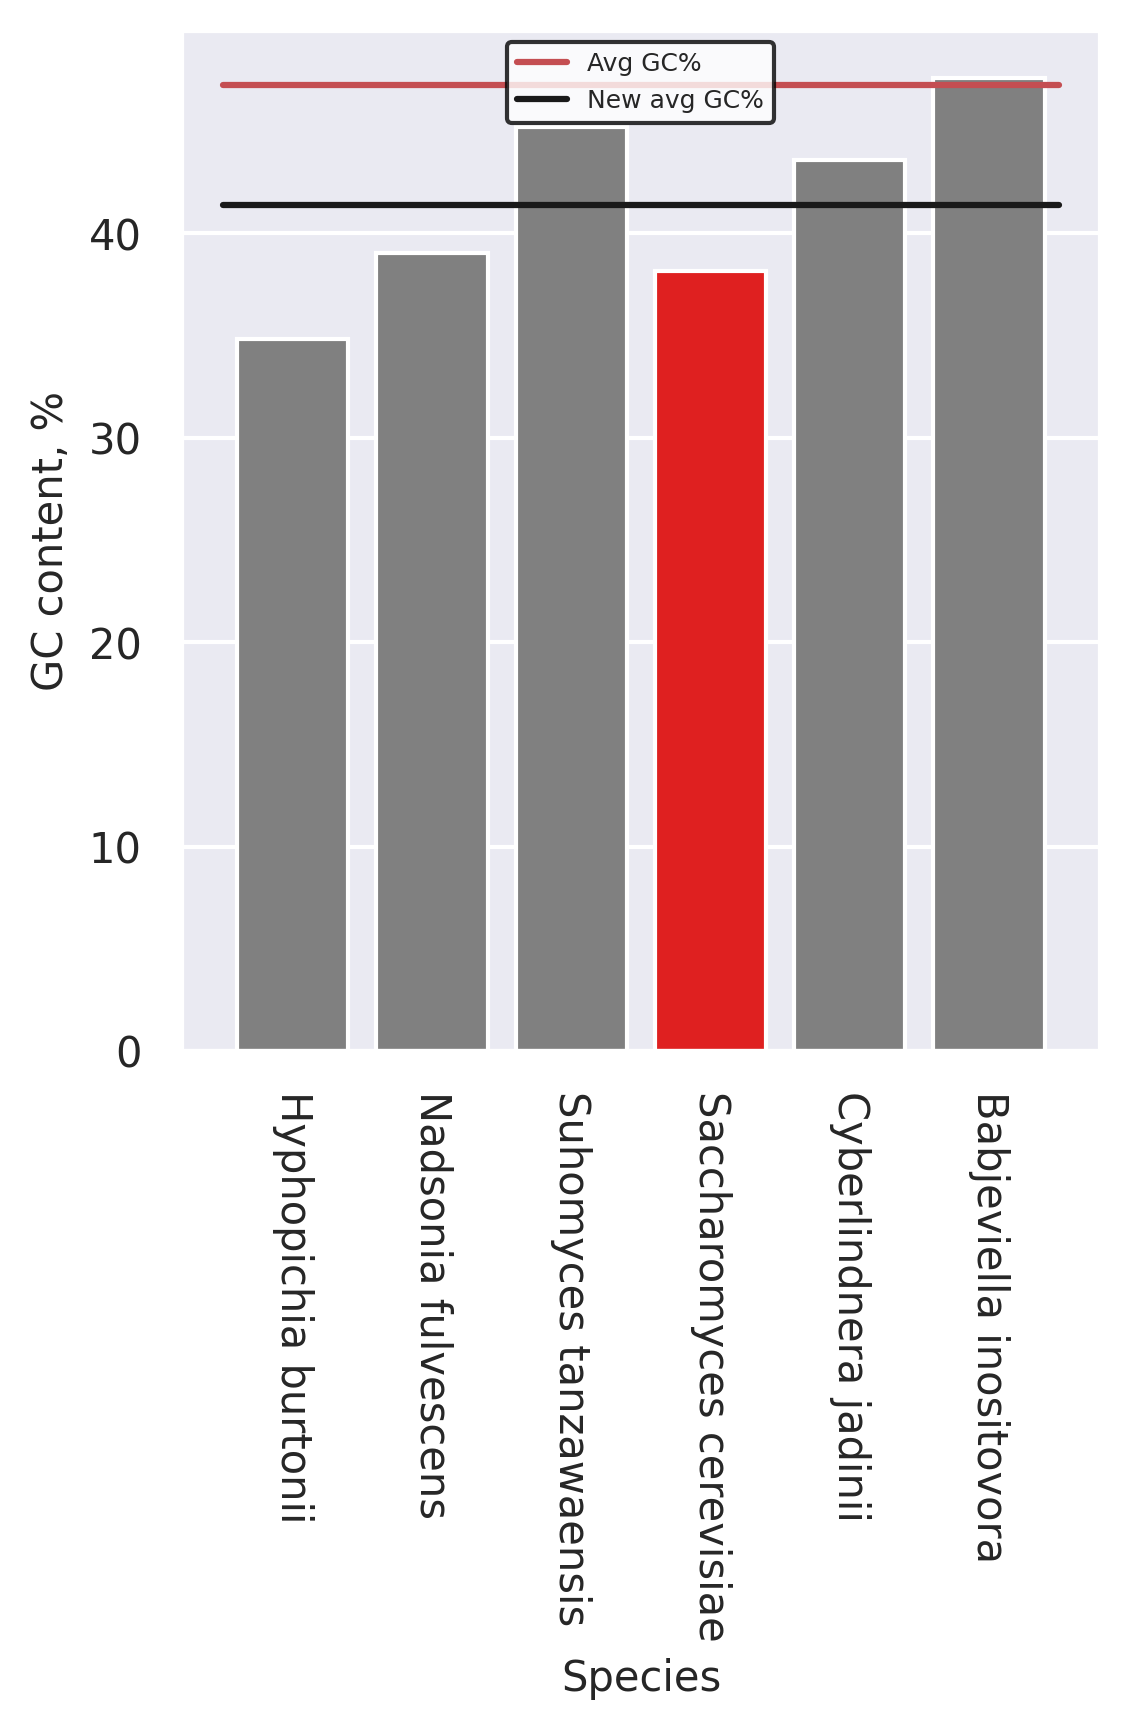

In [50]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize = (4,6))

cols = ['red' if x == sc_gc else 'grey' for x in subset_gc_df['gc percentage']]
gc_plot = sns.barplot(subset_gc_df, x = 'Species', y = 'gc percentage', palette = cols, width = 0.8)

gc_plot.tick_params(axis = 'x', rotation = -90, labelsize = 8)
gc_plot.tick_params(axis = 'y', labelsize = 8)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

avg_plot = plt.plot([-0.5, 5.5], [avg_gc, avg_gc], 'r')
ss_avg_plot = plt.plot([-0.5, 5.5], [ss_avg_gc, ss_avg_gc], 'k')
plt.legend([avg_plot[0], ss_avg_plot[0]], ['Avg GC%', 'New avg GC%'], 
           facecolor = 'white', edgecolor = 'black', fontsize = 6)

gc_plot.set_ylabel('GC content, %', fontsize = 10)
gc_plot.set_xlabel('Species', fontsize = 10)

plt.tight_layout()

plt.savefig('subset_gc_content.png')

#### 5 and 3 UTR

In [40]:
subset_med_5 = subset_utr5_df.groupby('species')['lengths'].median()
subset_highest_med_5 = subset_med_5.max()
subset_lowest_med_5 = subset_med_5.min()
subset_med_3 = subset_utr3_df.groupby('species')['lengths'].median()
highest_median_3 = subset_med_3.max()
lowest_median_3 = subset_med_3.min()

<Figure size 900x900 with 0 Axes>

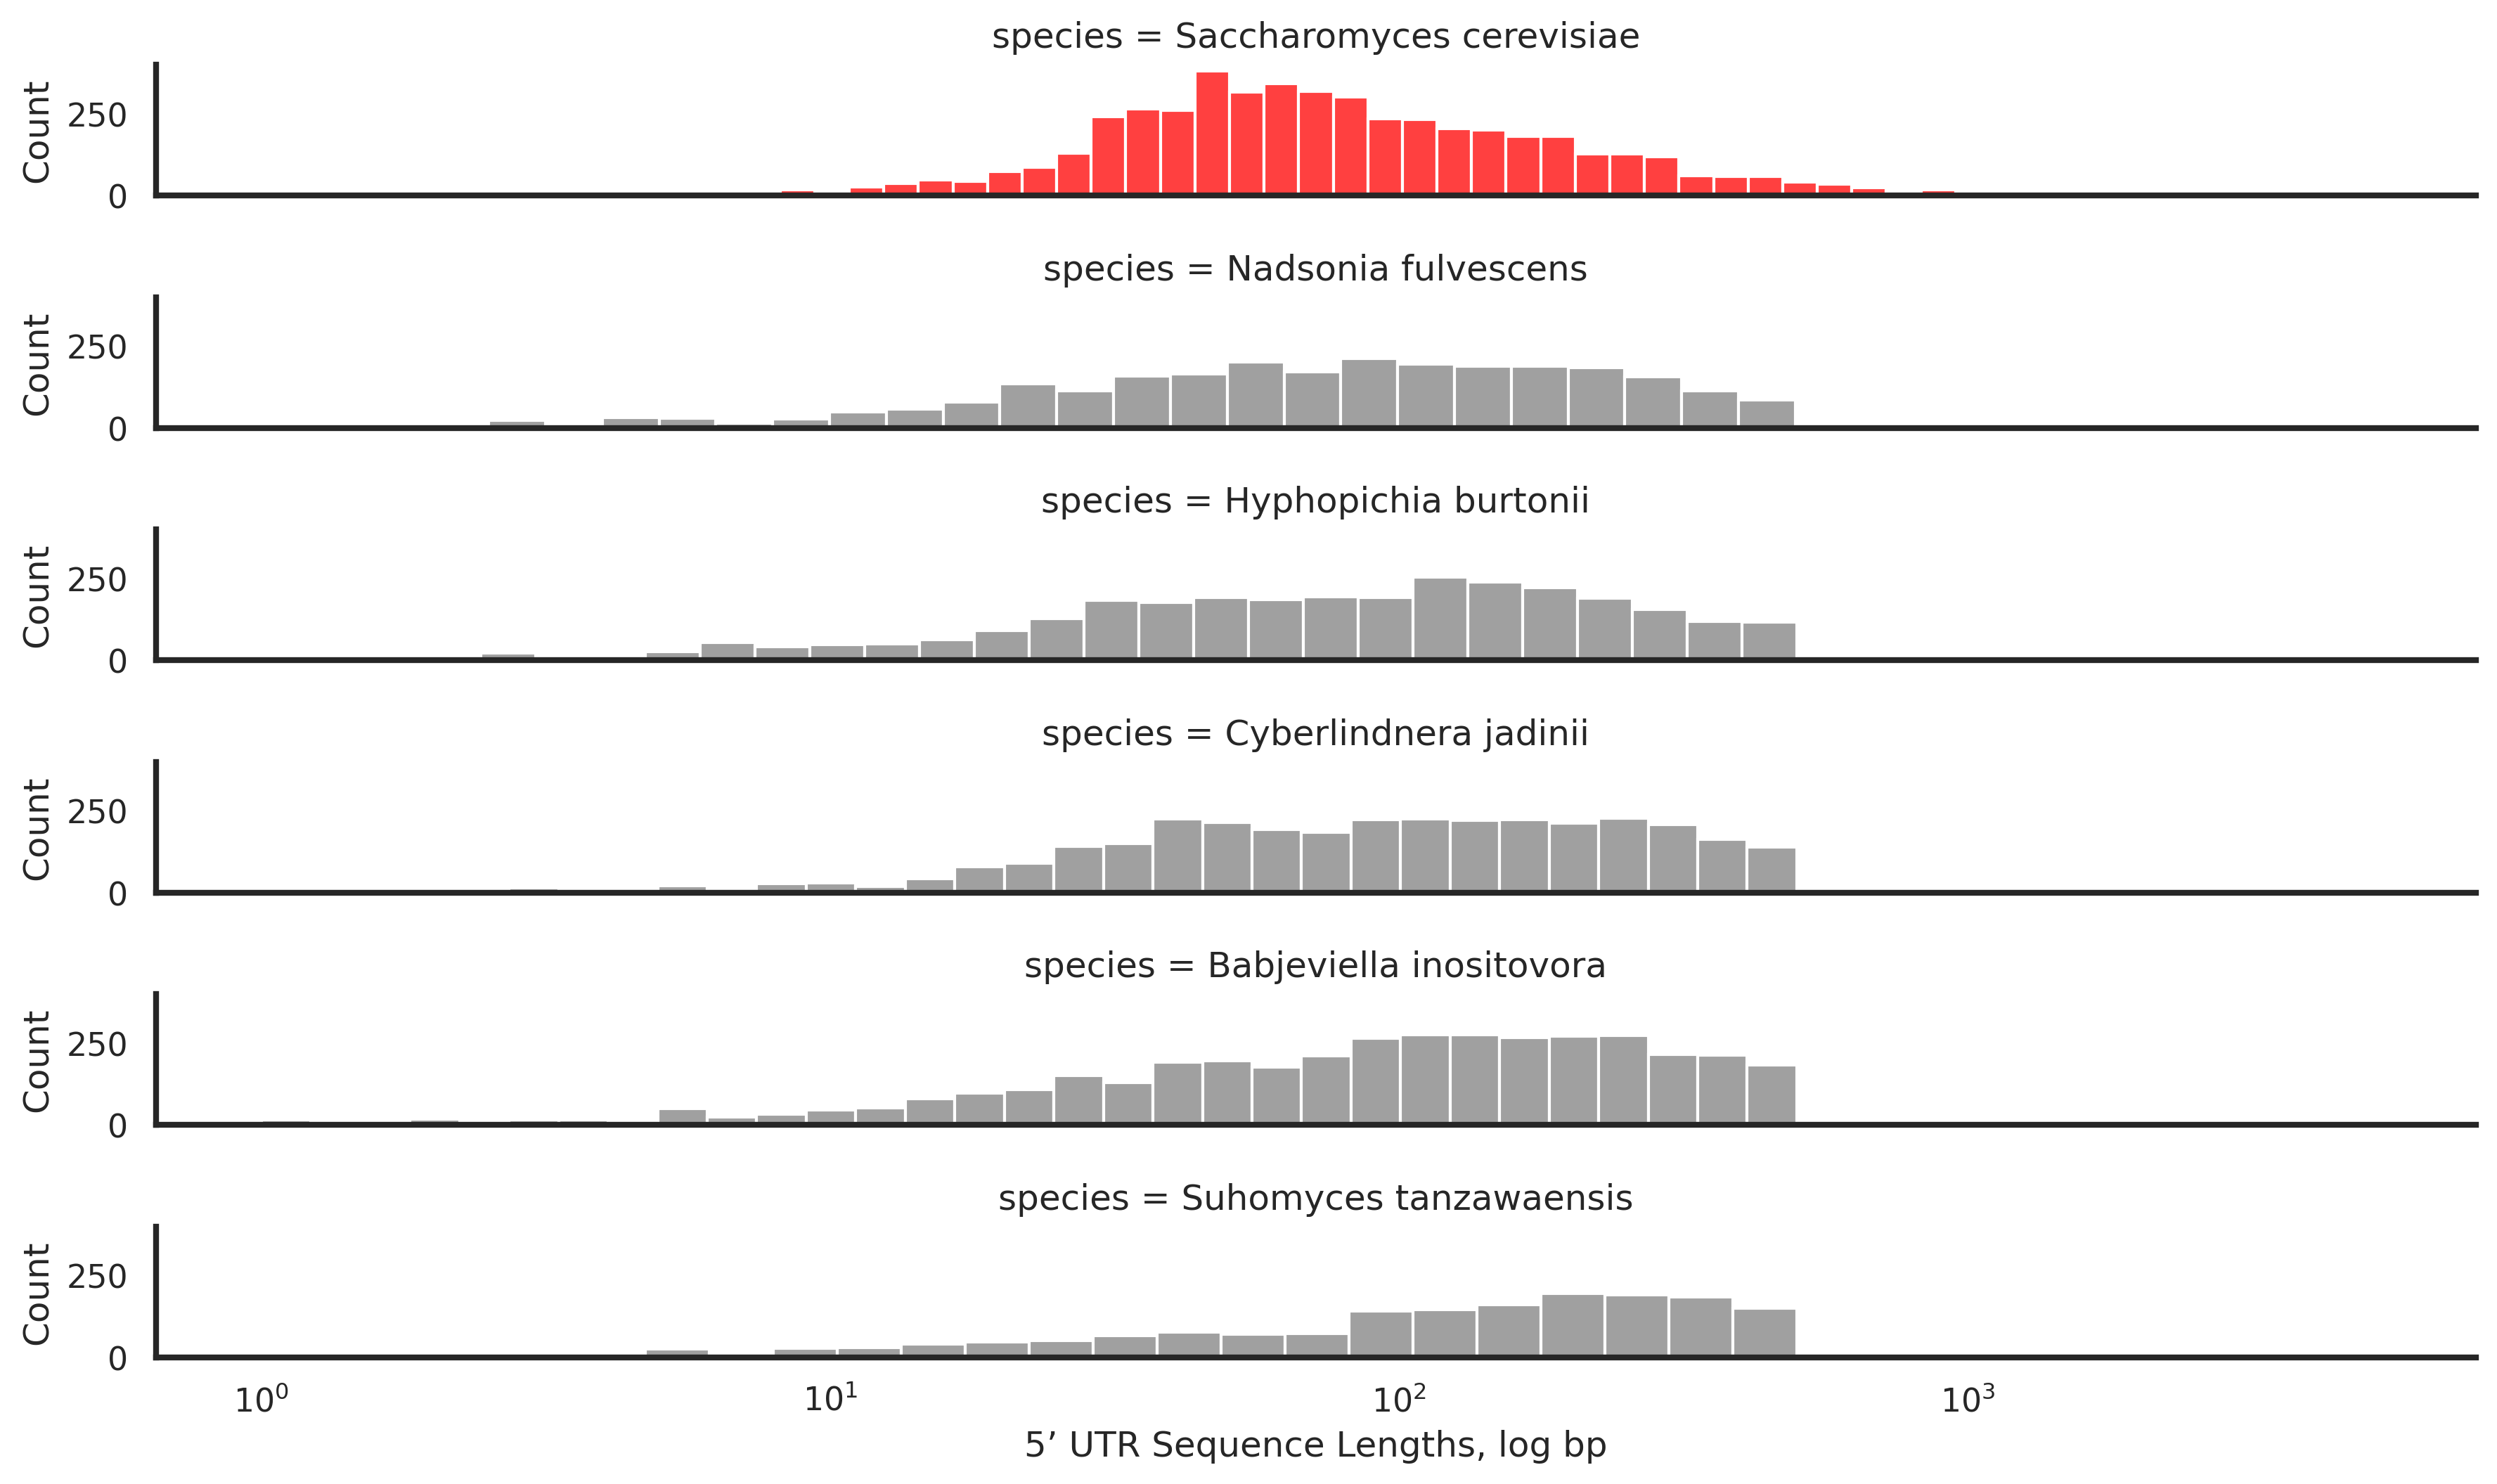

In [41]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3, 3))

sns.set_theme(style = "white", rc = {"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
species_palette = {'Saccharomyces cerevisiae': 'red', '': 'grey'}

palette = [species_palette.get(species, 'grey') for species in subset_utr5_df['species'].unique()]

medians = subset_utr5_df.groupby('species')['lengths'].median().sort_values().index
h_plot_5 = sns.FacetGrid(subset_utr5_df, row = 'species', hue = 'species', aspect = 10, height = 1.2,
                         row_order = medians, palette = palette)
h_plot_5.map_dataframe(sns.histplot, x = 'lengths', log_scale = True)
h_plot_5.set_axis_labels('5’ UTR Sequence Lengths, log bp', 'Count')
plt.tight_layout()

plt.savefig('subset_UTR5_lengths.pdf')

<Figure size 1800x900 with 0 Axes>

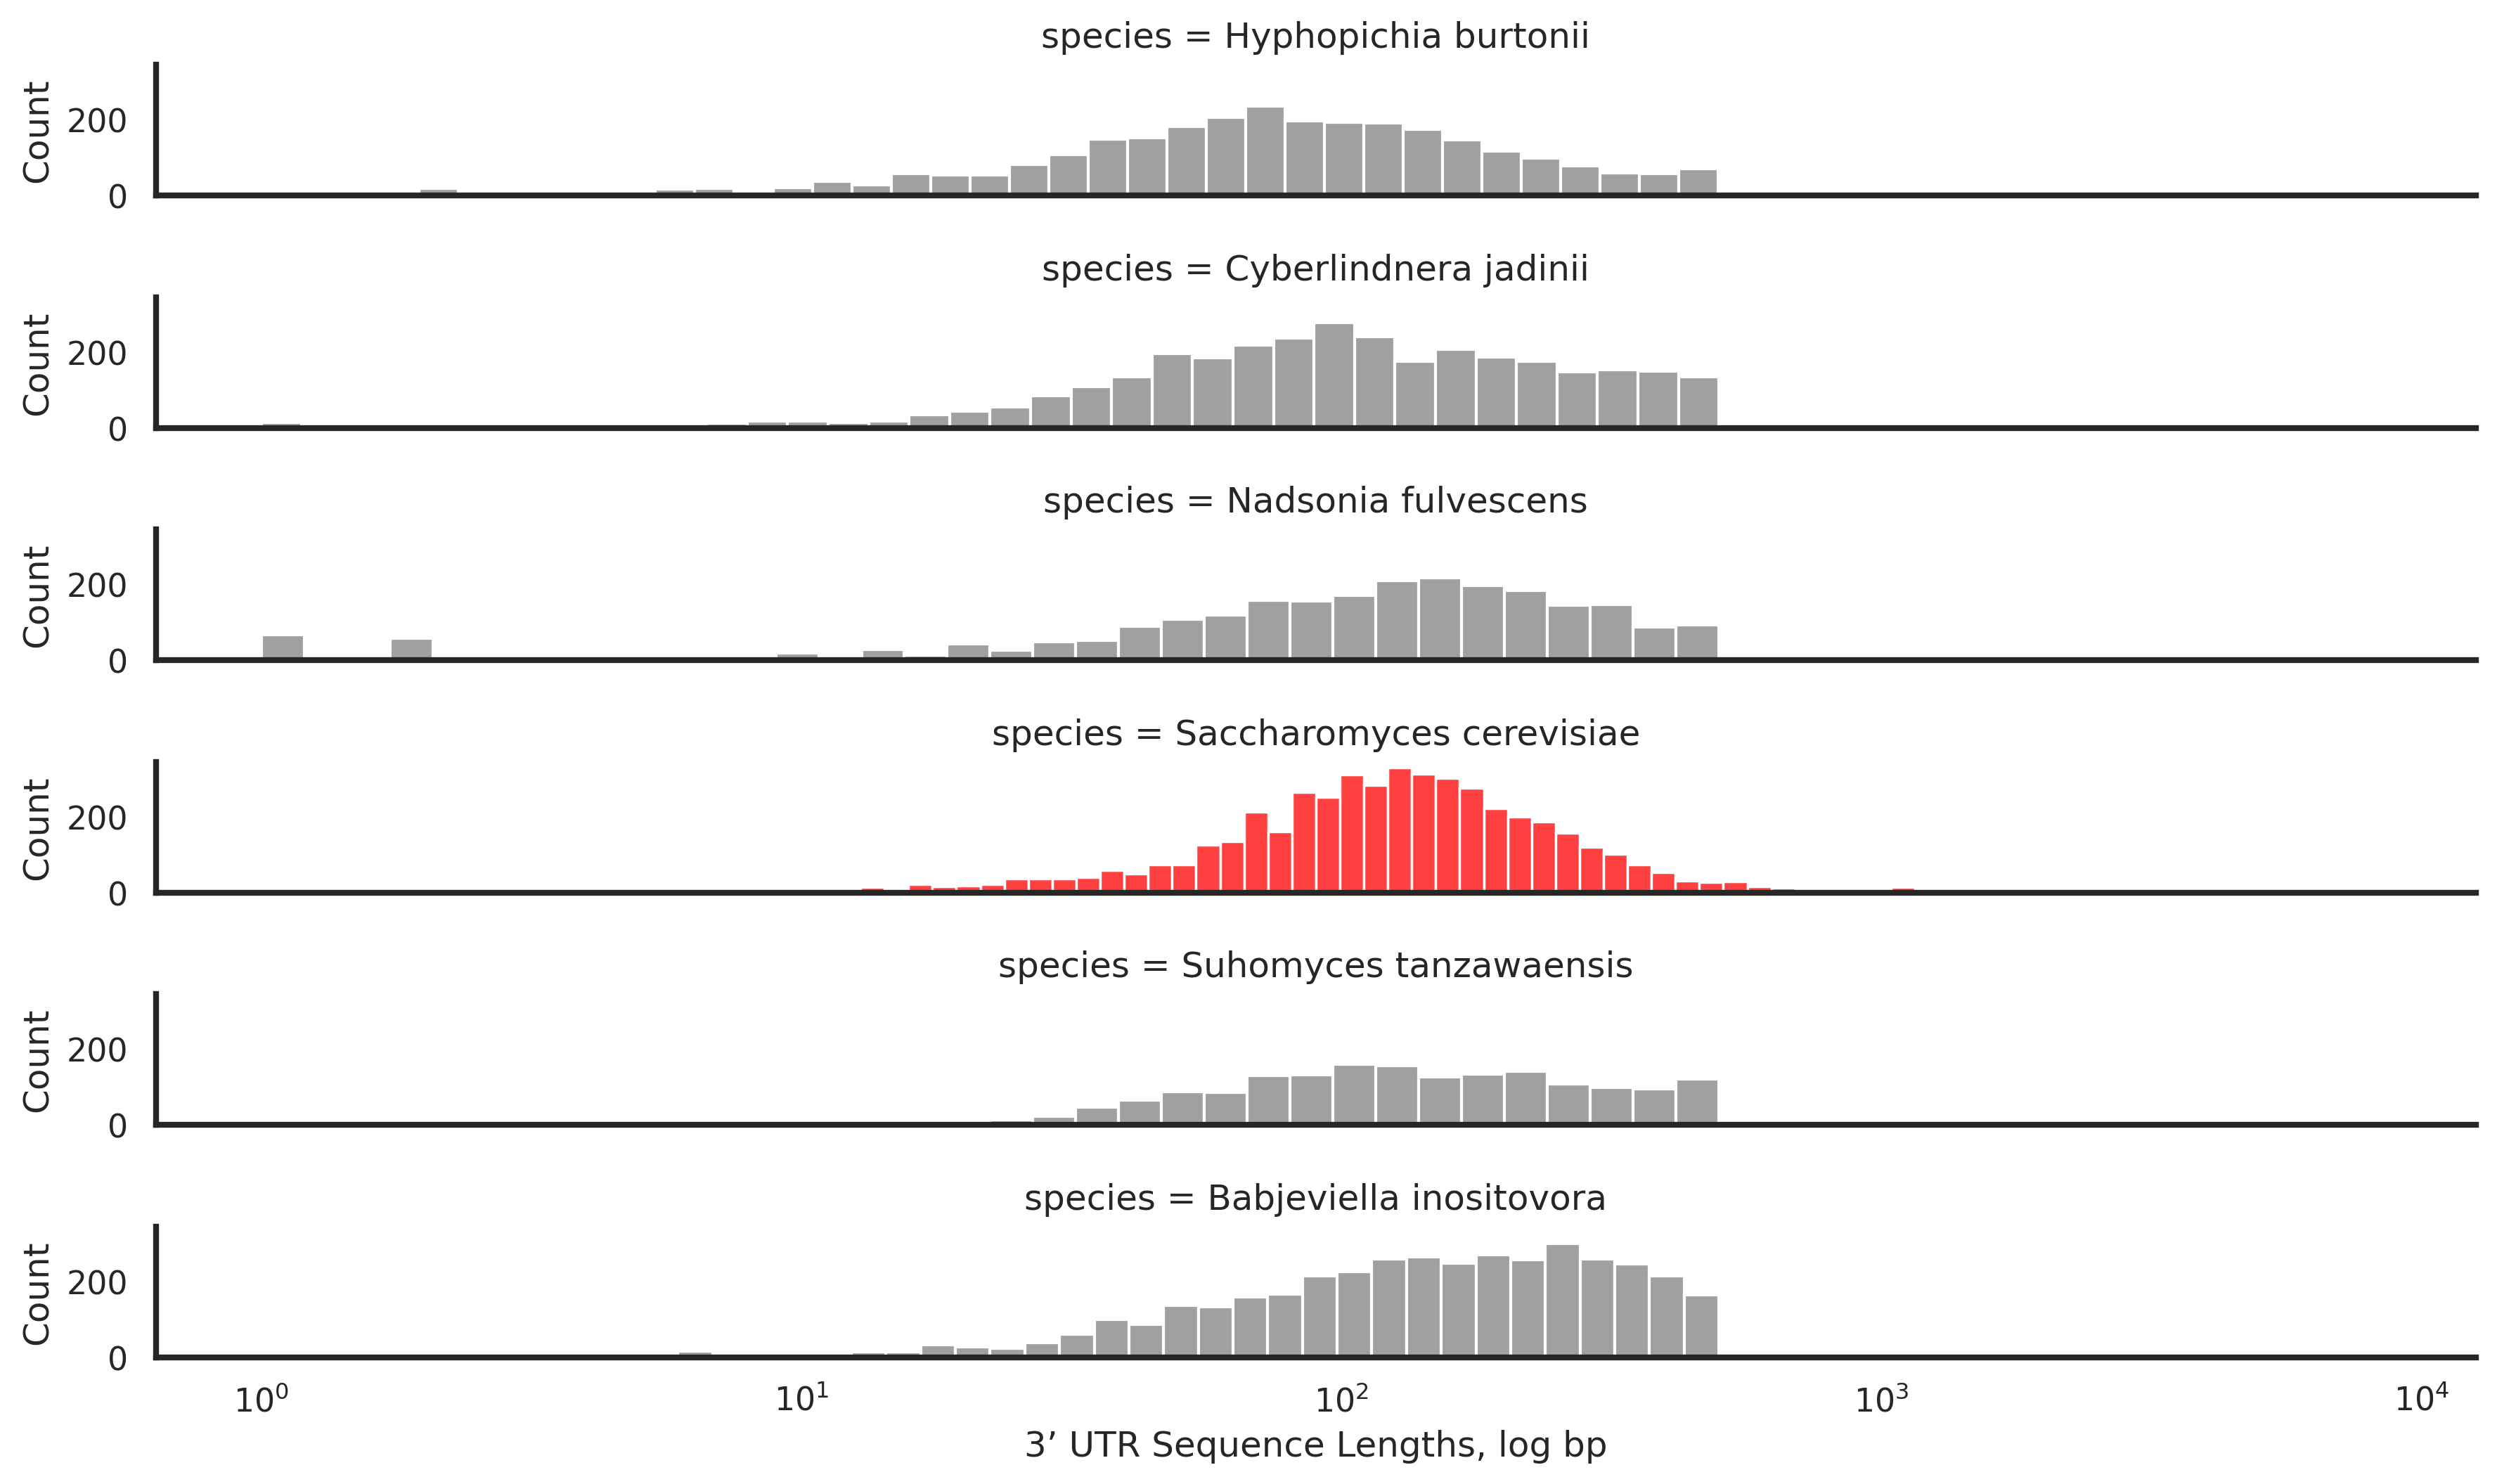

In [42]:
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 3))

sns.set_theme(style = "white", rc = {"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 2})
species_palette = {'Saccharomyces cerevisiae': 'red', '': 'grey'}

palette = [species_palette.get(species, 'grey') for species in subset_utr3_df['species'].unique()]

medians = subset_utr3_df.groupby('species')['lengths'].median().sort_values().index
h_plot_3 = sns.FacetGrid(subset_utr3_df, row = 'species', hue = 'species', aspect = 10, height = 1.2,
                         row_order = medians, palette = palette)
h_plot_3.map_dataframe(sns.histplot, x = 'lengths', log_scale = True)
h_plot_3.set_axis_labels('3’ UTR Sequence Lengths, log bp', 'Count')
plt.tight_layout()

plt.savefig('subset_UTR3_lengths.pdf')

#### Codon frequencies 

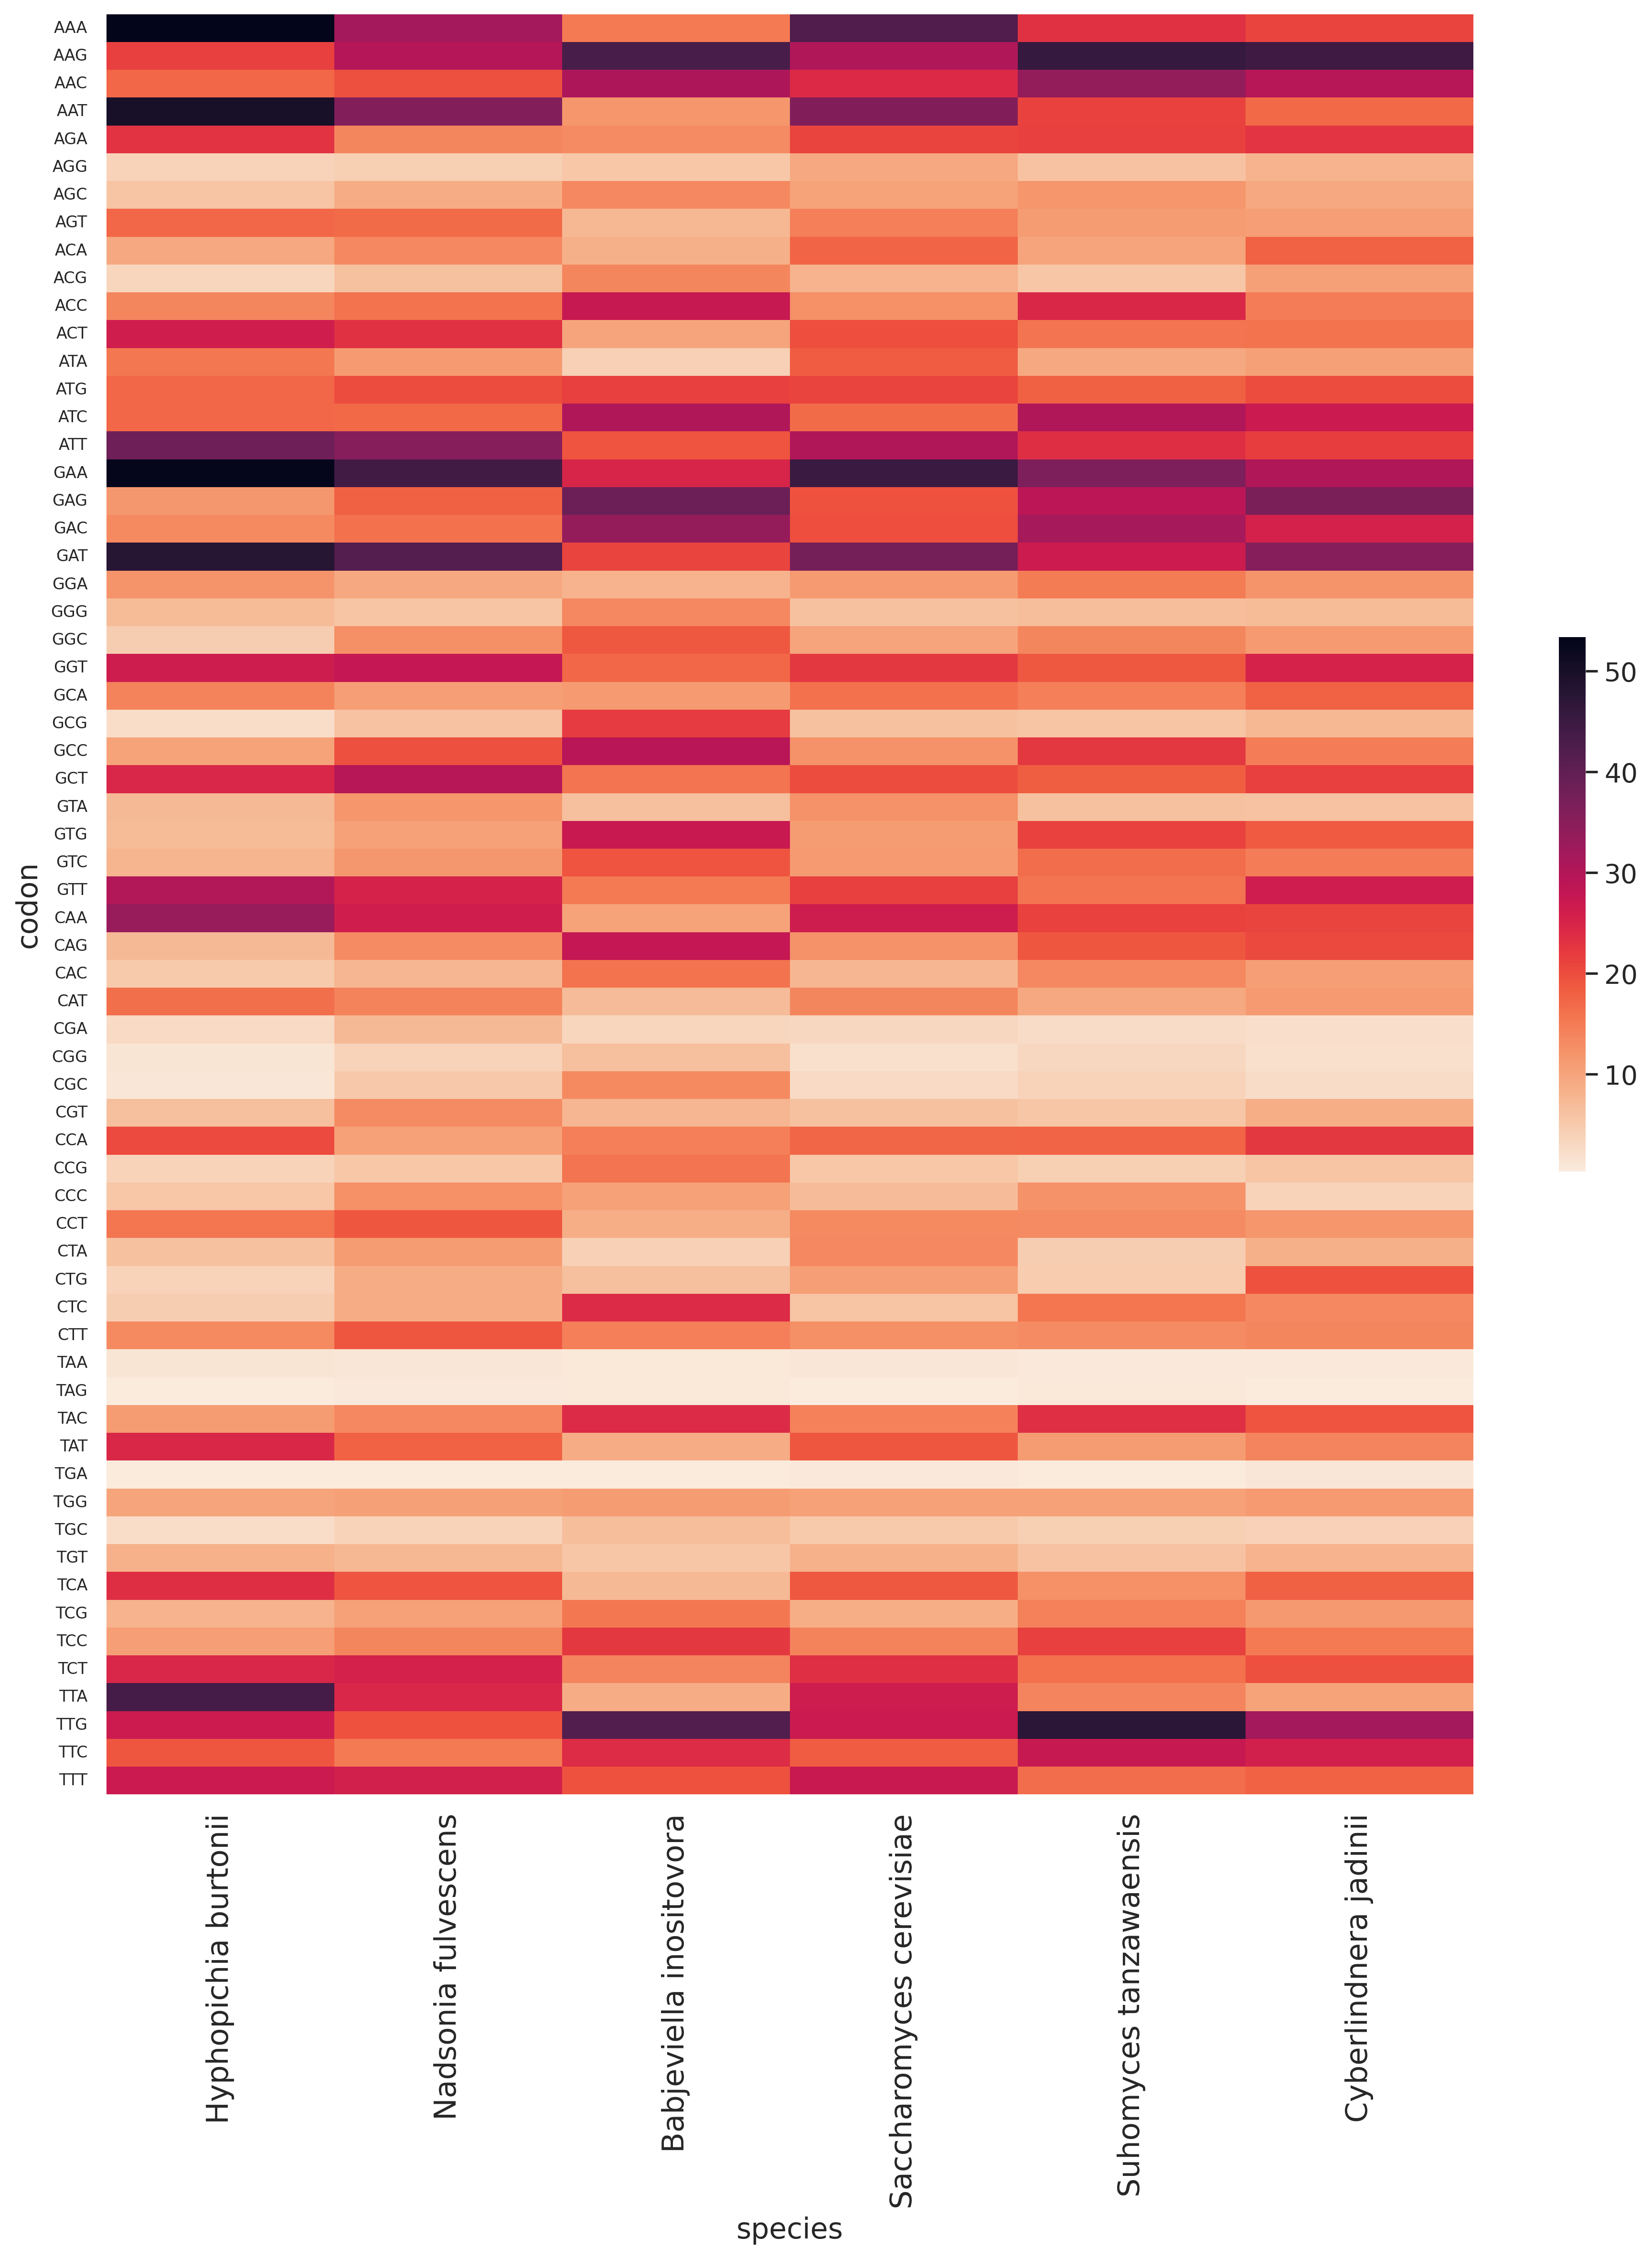

In [43]:
plt.figure(figsize = (13, 16))
sns.set(font_scale = 1.2)
cmap = sns.cm.rocket_r

f_heatmap = sns.heatmap(subset_heatmap_df, cbar_kws = {'shrink': 0.3}, cmap = cmap)

f_heatmap.set_xticklabels(f_heatmap.get_xticklabels(), rotation = 90, fontsize = 15)
f_heatmap.set_yticklabels(f_heatmap.get_yticklabels(), fontsize = 8)

plt.tight_layout()
plt.savefig('subset_codon_heatmap.png')
plt.show()